# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.208870795028335 -2.5781655146810603
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [34]:
# Data of the model
def model_input(state_size, lstm_size, batch_size=1):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    # GRU: Gated Recurrent Units
    gru = tf.nn.rnn_cell.GRUCell(lstm_size) # hidden size
    cell = tf.nn.rnn_cell.MultiRNNCell([gru], state_is_tuple=False)
    g_initial_state = cell.zero_state(batch_size, tf.float32) # feedback or lateral/recurrent connection from output
    d_initial_state = cell.zero_state(batch_size, tf.float32) # feedback or lateral/recurrent connection from output
    return states, actions, targetQs, cell, g_initial_state, d_initial_state

In [35]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [36]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [37]:
# MLP & Conv
# # Generator/Controller: Generating/prediting the actions
# def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
#     with tf.variable_scope('generator', reuse=reuse):
#         # First fully connected layer
#         h1 = tf.layers.dense(inputs=states, units=hidden_size)
#         bn1 = tf.layers.batch_normalization(h1, training=training)        
#         nl1 = tf.maximum(alpha * bn1, bn1)
        
#         # Second fully connected layer
#         h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
#         bn2 = tf.layers.batch_normalization(h2, training=training)        
#         nl2 = tf.maximum(alpha * bn2, bn2)
        
#         # Output layer
#         logits = tf.layers.dense(inputs=nl2, units=action_size)        
#         #predictions = tf.nn.softmax(logits)

#         # return actions logits
#         return logits

In [38]:
# RNN generator or sequence generator
def generator(states, initial_state, cell, lstm_size, num_classes, reuse=False): 
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        inputs = tf.layers.dense(inputs=states, units=lstm_size)
        print(states.shape, inputs.shape)
        
        # with tf.variable_scope('dynamic_rnn_', reuse=tf.AUTO_REUSE):
        # dynamic means adapt to the batch_size
        inputs_rnn = tf.reshape(inputs, [1, -1, lstm_size]) # NxH -> 1xNxH
        print(inputs_rnn.shape, initial_state.shape)
        outputs_rnn, final_state = tf.nn.dynamic_rnn(cell=cell, inputs=inputs_rnn, initial_state=initial_state)
        print(outputs_rnn.shape, final_state.shape)
        outputs = tf.reshape(outputs_rnn, [-1, lstm_size]) # 1xNxH -> NxH
        print(outputs.shape)

        # Last fully connected layer
        logits = tf.layers.dense(inputs=outputs, units=num_classes)
        print(logits.shape)
        #predictions = tf.nn.softmax(logits)
        
        # logits are the action logits
        return logits, final_state

In [39]:
# MLP & Conv
# # Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
# def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
#     with tf.variable_scope('discriminator', reuse=reuse):
#         # Fusion/merge states and actions/ SA/ SM
#         x_fused = tf.concat(axis=1, values=[states, actions])
        
#         # First fully connected layer
#         h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
#         bn1 = tf.layers.batch_normalization(h1, training=training)        
#         nl1 = tf.maximum(alpha * bn1, bn1)
        
#         # Second fully connected layer
#         h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
#         bn2 = tf.layers.batch_normalization(h2, training=training)        
#         nl2 = tf.maximum(alpha * bn2, bn2)
        
#         # Output layer
#         logits = tf.layers.dense(inputs=nl2, units=1)        
#         #predictions = tf.nn.softmax(logits)

#         # return rewards logits
#         return logits

In [40]:
# RNN generator or sequence generator
def discriminator(states, actions, initial_state, cell, lstm_size, reuse=False): 
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        inputs = tf.layers.dense(inputs=x_fused, units=lstm_size)
        print(states.shape, inputs.shape)
        
        # with tf.variable_scope('dynamic_rnn_', reuse=tf.AUTO_REUSE):
        inputs_rnn = tf.reshape(inputs, [1, -1, lstm_size]) # NxH -> 1xNxH
        print(inputs_rnn.shape, initial_state.shape)
        outputs_rnn, final_state = tf.nn.dynamic_rnn(cell=cell, inputs=inputs_rnn, initial_state=initial_state)
        print(outputs_rnn.shape, final_state.shape)
        outputs = tf.reshape(outputs_rnn, [-1, lstm_size]) # 1xNxH -> NxH
        print(outputs.shape)

        # Last fully connected layer
        logits = tf.layers.dense(inputs=outputs, units=1)
        print(logits.shape)
        #predictions = tf.nn.softmax(logits)
        
        # logits are the action logits
        return logits, final_state

In [41]:
def model_loss(action_size, hidden_size, states, actions, targetQs,
               cell, g_initial_state, d_initial_state):
    # G/Actor
    #actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_logits, g_final_state = generator(states=states, num_classes=action_size, 
                                              cell=cell, initial_state=g_initial_state, lstm_size=hidden_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    g_loss = tf.reduce_mean(neg_log_prob_actions * targetQs)
    
    # D/Critic
    #Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    Qs_logits, d_final_state = discriminator(states=states, actions=actions_logits, 
                                             cell=cell, initial_state=d_initial_state, lstm_size=hidden_size)
    d_lossQ = tf.reduce_mean(tf.square(tf.reshape(Qs_logits, [-1]) - targetQs))
    d_lossQ_sigm = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                          labels=tf.nn.sigmoid(targetQs)))
    d_loss = d_lossQ_sigm + d_lossQ

    return actions_logits, Qs_logits, g_final_state, d_final_state, g_loss, d_loss, d_lossQ, d_lossQ_sigm

In [42]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize RNN
    # g_grads, _ = tf.clip_by_global_norm(t_list=tf.gradients(g_loss, g_vars), clip_norm=5) # usually around 1-5
    # d_grads, _ = tf.clip_by_global_norm(t_list=tf.gradients(d_loss, d_vars), clip_norm=5) # usually around 1-5
    g_grads=tf.gradients(g_loss, g_vars)
    d_grads=tf.gradients(d_loss, d_vars)
    g_opt = tf.train.AdamOptimizer(learning_rate).apply_gradients(grads_and_vars=zip(g_grads, g_vars))
    d_opt = tf.train.AdamOptimizer(learning_rate).apply_gradients(grads_and_vars=zip(d_grads, d_vars))
    
    # # Optimize MLP & CNN
    # with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
    #     g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
    #     d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [43]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, cell, self.g_initial_state, self.d_initial_state = model_input(
            state_size=state_size, lstm_size=hidden_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_final_state, self.d_final_state, self.g_loss, self.d_loss, self.d_lossQ, self.d_lossQ_sigm = model_loss(
            action_size=action_size, hidden_size=hidden_size,
            states=self.states, actions=self.actions, cell=cell, targetQs=self.targetQs,
            g_initial_state=self.g_initial_state, d_initial_state=self.d_initial_state)
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

In [44]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
        self.states = deque(maxlen=max_size)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [45]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [46]:
# Training parameters
# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
batch_size = 32                # number of samples in the memory/ experience as mini-batch size
learning_rate = 0.001          # learning rate for adam

In [47]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

(?, 4) (?, 64)
(1, ?, 64) (1, 64)
(1, ?, 64) (1, 64)
(?, 64)
(?, 2)
(?, 4) (?, 64)
(1, ?, 64) (1, 64)
(1, ?, 64) (1, 64)
(?, 64)
(?, 1)


In [48]:
state = env.reset()
for _ in range(batch_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

In [49]:
memory.buffer[0]

[array([-0.01069676, -0.00322705,  0.03619071, -0.03418689]),
 0,
 array([-0.0107613 , -0.19884879,  0.03550697,  0.26969134]),
 1.0,
 0.0]

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [50]:
from collections import deque
episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossQ_list, d_lossQsigm_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(11111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state
        g_initial_state = sess.run(model.g_initial_state)
        d_initial_state = sess.run(model.d_initial_state)

        # Training steps/batches
        while True:
            # Testing/inference
            action_logits, g_final_state, d_final_state = sess.run(
                fetches=[model.actions_logits, model.g_final_state, model.d_final_state], 
                feed_dict={model.states: np.reshape(state, [1, -1]),
                           model.g_initial_state: g_initial_state,
                           model.d_initial_state: d_initial_state})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.states.append([g_initial_state, g_final_state,
                                  d_initial_state, d_final_state])
            total_reward += reward
            g_initial_state = g_final_state
            d_initial_state = d_final_state
            state = next_state
            
            # Training
            batch = memory.buffer
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            rnn_states = memory.states
            g_initial_states = np.array([each[0] for each in rnn_states])
            g_final_states = np.array([each[1] for each in rnn_states])
            d_initial_states = np.array([each[2] for each in rnn_states])
            d_final_states = np.array([each[3] for each in rnn_states])
            nextQs_logits = sess.run(fetches = model.Qs_logits,
                                     feed_dict = {model.states: next_states, 
                                                  model.g_initial_state: g_final_states[0].reshape([1, -1]),
                                                  model.d_initial_state: d_final_states[0].reshape([1, -1])})
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # exploit
            targetQs = rewards + (0.99 * nextQs)
            g_loss, d_loss, d_lossQ, d_lossQsigm, _, _ = sess.run(
                fetches=[model.g_loss, model.d_loss, 
                         model.d_lossQ, model.d_lossQ_sigm,
                         model.g_opt, model.d_opt], 
                feed_dict = {model.states: states, model.actions: actions,
                             model.targetQs: targetQs,
                             model.g_initial_state: g_initial_states[0].reshape([1, -1]),
                             model.d_initial_state: d_initial_states[0].reshape([1, -1])})

            if done is True:
                break

        # Episode total reward and success rate/prob
        episode_reward.append(total_reward) # stopping criteria
        rate = total_reward/ 500 # success is 500 points: 0-1
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossQ:{:.4f}'.format(d_lossQ),
              'dlossQsigm:{:.4f}'.format(d_lossQsigm))
        # Ploting out
        rewards_list.append([ep, np.mean(episode_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossQ_list.append([ep, d_lossQ])
        d_lossQsigm_list.append([ep, d_lossQsigm])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:48.0000 rate:0.0960 gloss:0.5152 dloss:1.4261 dlossQ:0.9713 dlossQsigm:0.4548
Episode:1 meanR:54.0000 rate:0.1200 gloss:0.1059 dloss:3.5117 dlossQ:3.4335 dlossQsigm:0.0782
Episode:2 meanR:59.6667 rate:0.1420 gloss:0.0066 dloss:8.2521 dlossQ:8.1162 dlossQsigm:0.1359
Episode:3 meanR:60.7500 rate:0.1280 gloss:0.0627 dloss:9.2201 dlossQ:9.0784 dlossQsigm:0.1416
Episode:4 meanR:56.0000 rate:0.0740 gloss:0.2940 dloss:3.9147 dlossQ:3.8604 dlossQsigm:0.0543
Episode:5 meanR:62.0000 rate:0.1840 gloss:0.0487 dloss:18.0800 dlossQ:17.8812 dlossQsigm:0.1988
Episode:6 meanR:60.4286 rate:0.1020 gloss:0.1382 dloss:9.5126 dlossQ:9.3767 dlossQsigm:0.1359
Episode:7 meanR:59.5000 rate:0.1060 gloss:0.1514 dloss:5.9219 dlossQ:5.7190 dlossQsigm:0.2029
Episode:8 meanR:57.3333 rate:0.0800 gloss:-14.5985 dloss:17.7668 dlossQ:17.2592 dlossQsigm:0.5076
Episode:9 meanR:57.4000 rate:0.1160 gloss:0.0268 dloss:11.9522 dlossQ:11.5416 dlossQsigm:0.4106
Episode:10 meanR:71.7273 rate:0.4300 gloss:0.0039 dl

Episode:85 meanR:148.3256 rate:0.3600 gloss:0.0047 dloss:38.6580 dlossQ:38.3657 dlossQsigm:0.2922
Episode:86 meanR:152.3678 rate:1.0000 gloss:1.2108 dloss:256.4392 dlossQ:255.6707 dlossQsigm:0.7685
Episode:87 meanR:156.3182 rate:1.0000 gloss:0.4264 dloss:252.4097 dlossQ:251.6474 dlossQsigm:0.7624
Episode:88 meanR:157.3708 rate:0.5000 gloss:1.0918 dloss:138.2171 dlossQ:137.6527 dlossQsigm:0.5644
Episode:89 meanR:161.1778 rate:1.0000 gloss:0.0297 dloss:254.4239 dlossQ:253.6584 dlossQsigm:0.7654
Episode:90 meanR:164.9011 rate:1.0000 gloss:1.4100 dloss:197.7912 dlossQ:197.1163 dlossQsigm:0.6749
Episode:91 meanR:168.5435 rate:1.0000 gloss:1.1271 dloss:235.4438 dlossQ:234.7076 dlossQsigm:0.7363
Episode:92 meanR:172.1075 rate:1.0000 gloss:0.1981 dloss:241.4702 dlossQ:240.7243 dlossQsigm:0.7459
Episode:93 meanR:172.5957 rate:0.4360 gloss:1.3309 dloss:91.2905 dlossQ:90.8382 dlossQsigm:0.4523
Episode:94 meanR:174.5684 rate:0.7200 gloss:5.1505 dloss:185.7843 dlossQ:185.1308 dlossQsigm:0.6535
Epis

Episode:169 meanR:200.6100 rate:0.3380 gloss:0.0000 dloss:8.8003 dlossQ:8.6855 dlossQsigm:0.1148
Episode:170 meanR:203.4400 rate:1.0000 gloss:0.2001 dloss:240.8342 dlossQ:240.0894 dlossQsigm:0.7448
Episode:171 meanR:202.5600 rate:0.2240 gloss:0.0003 dloss:53.1096 dlossQ:52.9648 dlossQsigm:0.1448
Episode:172 meanR:202.5000 rate:0.2500 gloss:0.0003 dloss:38.9590 dlossQ:38.8438 dlossQsigm:0.1153
Episode:173 meanR:205.6800 rate:1.0000 gloss:0.4299 dloss:183.6344 dlossQ:182.9998 dlossQsigm:0.6346
Episode:174 meanR:208.9000 rate:1.0000 gloss:0.0000 dloss:181.7921 dlossQ:181.1445 dlossQsigm:0.6477
Episode:175 meanR:207.7100 rate:0.2740 gloss:0.0000 dloss:179.5241 dlossQ:179.1520 dlossQsigm:0.3720
Episode:176 meanR:206.5000 rate:0.2980 gloss:0.0033 dloss:94.3131 dlossQ:93.8826 dlossQsigm:0.4304
Episode:177 meanR:205.7900 rate:0.3720 gloss:0.0000 dloss:61.4041 dlossQ:61.0289 dlossQsigm:0.3752
Episode:178 meanR:208.7100 rate:1.0000 gloss:0.1163 dloss:232.9000 dlossQ:232.1681 dlossQsigm:0.7319
Ep

Episode:251 meanR:343.5800 rate:0.3740 gloss:0.0004 dloss:192.5699 dlossQ:191.9044 dlossQsigm:0.6654
Episode:252 meanR:347.6600 rate:1.0000 gloss:0.1996 dloss:199.9042 dlossQ:199.2254 dlossQsigm:0.6788
Episode:253 meanR:348.4300 rate:0.3420 gloss:0.0000 dloss:160.6407 dlossQ:160.0313 dlossQsigm:0.6094
Episode:254 meanR:352.2600 rate:1.0000 gloss:0.0000 dloss:191.3875 dlossQ:190.7227 dlossQsigm:0.6648
Episode:255 meanR:353.6600 rate:0.4740 gloss:0.0000 dloss:189.1950 dlossQ:188.5349 dlossQsigm:0.6602
Episode:256 meanR:354.2800 rate:0.3500 gloss:0.0000 dloss:169.7405 dlossQ:169.1141 dlossQsigm:0.6263
Episode:257 meanR:357.4400 rate:0.8800 gloss:0.0000 dloss:188.2865 dlossQ:187.6269 dlossQsigm:0.6595
Episode:258 meanR:357.9200 rate:0.3240 gloss:0.0000 dloss:173.3106 dlossQ:172.6776 dlossQsigm:0.6330
Episode:259 meanR:358.3200 rate:0.3320 gloss:0.0000 dloss:172.0706 dlossQ:171.4398 dlossQsigm:0.6307
Episode:260 meanR:358.4800 rate:0.3400 gloss:0.0005 dloss:162.8668 dlossQ:162.2529 dlossQsi

Episode:333 meanR:254.6300 rate:0.5160 gloss:0.0000 dloss:128.2273 dlossQ:127.6820 dlossQsigm:0.5453
Episode:334 meanR:250.9100 rate:0.2560 gloss:0.0003 dloss:123.1977 dlossQ:122.6631 dlossQsigm:0.5346
Episode:335 meanR:247.2100 rate:0.2600 gloss:0.0000 dloss:124.0608 dlossQ:123.5243 dlossQsigm:0.5365
Episode:336 meanR:243.4600 rate:0.2500 gloss:0.0000 dloss:119.2823 dlossQ:118.7561 dlossQsigm:0.5262
Episode:337 meanR:239.6500 rate:0.2380 gloss:0.0000 dloss:114.9189 dlossQ:114.4023 dlossQsigm:0.5166
Episode:338 meanR:238.9900 rate:0.2240 gloss:0.0000 dloss:110.3908 dlossQ:109.8844 dlossQsigm:0.5064
Episode:339 meanR:235.3300 rate:0.2680 gloss:0.0002 dloss:109.7796 dlossQ:109.2749 dlossQsigm:0.5047
Episode:340 meanR:231.6200 rate:0.2580 gloss:0.0000 dloss:109.0042 dlossQ:108.5009 dlossQsigm:0.5033
Episode:341 meanR:227.6900 rate:0.2140 gloss:0.0000 dloss:105.1620 dlossQ:104.6676 dlossQsigm:0.4944
Episode:342 meanR:227.5000 rate:0.3900 gloss:0.0001 dloss:113.1517 dlossQ:112.6395 dlossQsi

Episode:415 meanR:139.5300 rate:0.2160 gloss:0.0000 dloss:44.1564 dlossQ:43.8932 dlossQsigm:0.2633
Episode:416 meanR:138.9300 rate:0.2040 gloss:0.0000 dloss:45.3275 dlossQ:45.0721 dlossQsigm:0.2554
Episode:417 meanR:138.2400 rate:0.1640 gloss:0.0168 dloss:43.1972 dlossQ:42.1803 dlossQsigm:1.0169
Episode:418 meanR:137.7800 rate:0.2180 gloss:0.0057 dloss:118.6990 dlossQ:118.2887 dlossQsigm:0.4103
Episode:419 meanR:137.1500 rate:0.2120 gloss:0.0000 dloss:99.9956 dlossQ:99.5390 dlossQsigm:0.4566
Episode:420 meanR:136.6200 rate:0.2040 gloss:0.0000 dloss:106.3712 dlossQ:105.8896 dlossQsigm:0.4815
Episode:421 meanR:132.5800 rate:0.1920 gloss:0.0000 dloss:117.3470 dlossQ:116.8368 dlossQsigm:0.5102
Episode:422 meanR:131.5700 rate:0.2040 gloss:0.0015 dloss:42.6710 dlossQ:42.1993 dlossQsigm:0.4717
Episode:423 meanR:135.0900 rate:1.0000 gloss:1.7626 dloss:222.2460 dlossQ:221.5492 dlossQsigm:0.6968
Episode:424 meanR:134.6000 rate:0.1880 gloss:0.0000 dloss:69.0389 dlossQ:68.6453 dlossQsigm:0.3936
Ep

Episode:497 meanR:188.1600 rate:0.2540 gloss:0.0000 dloss:150.3830 dlossQ:149.7939 dlossQsigm:0.5891
Episode:498 meanR:188.0400 rate:0.1740 gloss:0.0000 dloss:80.0243 dlossQ:79.5931 dlossQsigm:0.4312
Episode:499 meanR:192.2100 rate:1.0000 gloss:0.0417 dloss:227.8918 dlossQ:227.1721 dlossQsigm:0.7197
Episode:500 meanR:192.6300 rate:0.2820 gloss:0.0000 dloss:132.7177 dlossQ:132.1688 dlossQsigm:0.5489
Episode:501 meanR:192.1900 rate:0.2200 gloss:0.0000 dloss:183.8793 dlossQ:183.2380 dlossQsigm:0.6413
Episode:502 meanR:192.1200 rate:0.1760 gloss:0.0000 dloss:166.5753 dlossQ:165.9578 dlossQsigm:0.6176
Episode:503 meanR:194.2100 rate:0.6080 gloss:0.0000 dloss:129.8027 dlossQ:129.2696 dlossQsigm:0.5331
Episode:504 meanR:194.4800 rate:0.2240 gloss:0.0000 dloss:141.1375 dlossQ:140.5830 dlossQsigm:0.5545
Episode:505 meanR:196.8400 rate:0.6480 gloss:0.0008 dloss:195.2205 dlossQ:194.5558 dlossQsigm:0.6647
Episode:506 meanR:196.6000 rate:0.2280 gloss:0.0000 dloss:114.0190 dlossQ:113.5099 dlossQsigm

Episode:579 meanR:198.7600 rate:0.5300 gloss:0.0000 dloss:126.5390 dlossQ:126.0645 dlossQsigm:0.4745
Episode:580 meanR:198.7900 rate:0.2500 gloss:0.0000 dloss:222.5580 dlossQ:221.8481 dlossQsigm:0.7098
Episode:581 meanR:202.4500 rate:1.0000 gloss:0.0318 dloss:218.2520 dlossQ:217.5433 dlossQsigm:0.7087
Episode:582 meanR:202.3000 rate:0.1760 gloss:0.0000 dloss:108.6745 dlossQ:108.1944 dlossQsigm:0.4801
Episode:583 meanR:206.4600 rate:1.0000 gloss:0.0028 dloss:220.4199 dlossQ:219.7075 dlossQsigm:0.7124
Episode:584 meanR:210.2800 rate:1.0000 gloss:0.0001 dloss:227.0298 dlossQ:226.3063 dlossQsigm:0.7235
Episode:585 meanR:213.9100 rate:1.0000 gloss:0.0013 dloss:226.5764 dlossQ:225.8536 dlossQsigm:0.7228
Episode:586 meanR:213.4800 rate:0.9140 gloss:0.0001 dloss:156.2690 dlossQ:155.6737 dlossQsigm:0.5953
Episode:587 meanR:209.6600 rate:0.2360 gloss:0.0000 dloss:233.2751 dlossQ:232.5570 dlossQsigm:0.7181
Episode:588 meanR:213.7200 rate:1.0000 gloss:0.0037 dloss:196.1691 dlossQ:195.4960 dlossQsi

Episode:661 meanR:277.5000 rate:0.1820 gloss:0.0040 dloss:120.2917 dlossQ:119.7650 dlossQsigm:0.5267
Episode:662 meanR:277.1400 rate:0.1980 gloss:0.0001 dloss:106.1621 dlossQ:105.6917 dlossQsigm:0.4704
Episode:663 meanR:273.4700 rate:0.2660 gloss:0.0000 dloss:106.9925 dlossQ:106.5017 dlossQsigm:0.4908
Episode:664 meanR:277.5600 rate:1.0000 gloss:0.0000 dloss:169.9553 dlossQ:169.3283 dlossQsigm:0.6270
Episode:665 meanR:277.9700 rate:0.2740 gloss:0.0000 dloss:149.1266 dlossQ:148.5419 dlossQsigm:0.5847
Episode:666 meanR:277.9700 rate:1.0000 gloss:0.0007 dloss:182.6054 dlossQ:181.9558 dlossQsigm:0.6496
Episode:667 meanR:282.0200 rate:1.0000 gloss:0.0189 dloss:207.9608 dlossQ:207.2687 dlossQsigm:0.6921
Episode:668 meanR:281.9700 rate:0.1940 gloss:0.0002 dloss:266.9171 dlossQ:266.1570 dlossQsigm:0.7601
Episode:669 meanR:286.1000 rate:1.0000 gloss:0.0881 dloss:159.2474 dlossQ:158.6416 dlossQsigm:0.6058
Episode:670 meanR:290.1100 rate:1.0000 gloss:0.0023 dloss:197.4972 dlossQ:196.8225 dlossQsi

Episode:743 meanR:226.6200 rate:1.0000 gloss:0.0000 dloss:230.2201 dlossQ:229.4915 dlossQsigm:0.7286
Episode:744 meanR:226.3300 rate:0.9420 gloss:0.0000 dloss:230.4700 dlossQ:229.7410 dlossQsigm:0.7290
Episode:745 meanR:226.4300 rate:0.1600 gloss:0.0000 dloss:133.2056 dlossQ:132.6910 dlossQsigm:0.5145
Episode:746 meanR:228.5200 rate:0.5880 gloss:0.0000 dloss:200.1514 dlossQ:199.4716 dlossQsigm:0.6798
Episode:747 meanR:230.1100 rate:1.0000 gloss:0.0011 dloss:213.5403 dlossQ:212.8384 dlossQsigm:0.7020
Episode:748 meanR:231.2000 rate:1.0000 gloss:0.0005 dloss:222.4349 dlossQ:221.7186 dlossQsigm:0.7163
Episode:749 meanR:227.3800 rate:0.2360 gloss:0.0000 dloss:204.0484 dlossQ:203.3627 dlossQsigm:0.6857
Episode:750 meanR:223.2600 rate:0.1760 gloss:0.0001 dloss:199.8983 dlossQ:199.2779 dlossQsigm:0.6204
Episode:751 meanR:227.5200 rate:1.0000 gloss:0.0003 dloss:196.3666 dlossQ:195.6931 dlossQsigm:0.6734
Episode:752 meanR:230.9600 rate:1.0000 gloss:0.0044 dloss:211.5327 dlossQ:210.8341 dlossQsi

Episode:825 meanR:252.3200 rate:0.2000 gloss:0.0000 dloss:146.7959 dlossQ:146.2128 dlossQsigm:0.5831
Episode:826 meanR:252.5300 rate:0.2060 gloss:0.0000 dloss:109.2681 dlossQ:108.7701 dlossQsigm:0.4980
Episode:827 meanR:252.4400 rate:0.1600 gloss:0.0000 dloss:75.7660 dlossQ:75.3653 dlossQsigm:0.4007
Episode:828 meanR:252.4200 rate:0.1560 gloss:0.0000 dloss:76.9880 dlossQ:76.5993 dlossQsigm:0.3886
Episode:829 meanR:256.3800 rate:1.0000 gloss:0.0060 dloss:167.1447 dlossQ:166.5236 dlossQsigm:0.6211
Episode:830 meanR:256.8100 rate:0.2200 gloss:0.0000 dloss:115.3489 dlossQ:114.8544 dlossQsigm:0.4944
Episode:831 meanR:256.8800 rate:0.1940 gloss:0.0001 dloss:117.3978 dlossQ:116.9021 dlossQsigm:0.4957
Episode:832 meanR:252.8300 rate:0.1900 gloss:0.0000 dloss:60.4399 dlossQ:60.1497 dlossQsigm:0.2902
Episode:833 meanR:250.0700 rate:0.2360 gloss:0.0000 dloss:112.6155 dlossQ:112.1168 dlossQsigm:0.4988
Episode:834 meanR:250.6300 rate:0.2680 gloss:0.0000 dloss:74.4878 dlossQ:74.1092 dlossQsigm:0.378

Episode:907 meanR:208.8100 rate:0.5640 gloss:0.0000 dloss:159.1091 dlossQ:158.5023 dlossQsigm:0.6068
Episode:908 meanR:208.9700 rate:0.1800 gloss:0.0000 dloss:142.9810 dlossQ:142.4054 dlossQsigm:0.5756
Episode:909 meanR:208.7800 rate:0.1400 gloss:0.0000 dloss:128.3510 dlossQ:127.8054 dlossQsigm:0.5456
Episode:910 meanR:209.0800 rate:1.0000 gloss:0.2743 dloss:167.8333 dlossQ:167.2117 dlossQsigm:0.6217
Episode:911 meanR:209.2700 rate:0.1800 gloss:0.0000 dloss:149.2862 dlossQ:148.6982 dlossQsigm:0.5880
Episode:912 meanR:209.2700 rate:1.0000 gloss:0.0054 dloss:182.3827 dlossQ:181.7335 dlossQsigm:0.6492
Episode:913 meanR:209.1000 rate:0.2140 gloss:0.0000 dloss:162.6781 dlossQ:162.0646 dlossQsigm:0.6135
Episode:914 meanR:210.6100 rate:0.8100 gloss:0.0000 dloss:181.0288 dlossQ:180.3819 dlossQsigm:0.6468
Episode:915 meanR:210.1900 rate:0.1120 gloss:0.0000 dloss:141.2732 dlossQ:140.7010 dlossQsigm:0.5721
Episode:916 meanR:209.8600 rate:0.1620 gloss:0.0000 dloss:128.1710 dlossQ:127.6257 dlossQsi

Episode:989 meanR:141.5300 rate:0.1500 gloss:0.0003 dloss:57.6283 dlossQ:57.2724 dlossQsigm:0.3559
Episode:990 meanR:145.5000 rate:1.0000 gloss:0.4109 dloss:129.1706 dlossQ:128.6330 dlossQsigm:0.5375
Episode:991 meanR:145.7500 rate:0.1620 gloss:0.0000 dloss:110.2079 dlossQ:109.7021 dlossQsigm:0.5059
Episode:992 meanR:145.7100 rate:0.2140 gloss:0.0000 dloss:105.7358 dlossQ:105.2415 dlossQsigm:0.4943
Episode:993 meanR:141.4600 rate:0.1500 gloss:0.0000 dloss:97.5042 dlossQ:97.0286 dlossQsigm:0.4757
Episode:994 meanR:141.6700 rate:0.2040 gloss:0.0000 dloss:82.1534 dlossQ:81.7158 dlossQsigm:0.4376
Episode:995 meanR:141.7000 rate:0.1840 gloss:0.0003 dloss:84.5976 dlossQ:84.1553 dlossQsigm:0.4424
Episode:996 meanR:141.5600 rate:0.1540 gloss:0.0000 dloss:72.2756 dlossQ:71.8659 dlossQsigm:0.4097
Episode:997 meanR:144.7000 rate:0.7660 gloss:0.0000 dloss:109.1162 dlossQ:108.6138 dlossQsigm:0.5023
Episode:998 meanR:144.8000 rate:0.1460 gloss:0.0006 dloss:99.2666 dlossQ:98.7893 dlossQsigm:0.4774
Ep

Episode:1071 meanR:126.7600 rate:0.2240 gloss:0.0000 dloss:67.2344 dlossQ:66.8381 dlossQsigm:0.3963
Episode:1072 meanR:126.7100 rate:0.1700 gloss:0.0000 dloss:54.9580 dlossQ:54.6197 dlossQsigm:0.3383
Episode:1073 meanR:126.8100 rate:0.1820 gloss:0.0000 dloss:64.0987 dlossQ:63.7147 dlossQsigm:0.3840
Episode:1074 meanR:126.9000 rate:0.1420 gloss:0.0000 dloss:47.5205 dlossQ:47.1920 dlossQsigm:0.3285
Episode:1075 meanR:126.5200 rate:0.1480 gloss:0.0000 dloss:59.4361 dlossQ:59.0642 dlossQsigm:0.3719
Episode:1076 meanR:130.2800 rate:1.0000 gloss:0.0000 dloss:108.2648 dlossQ:107.7649 dlossQsigm:0.4999
Episode:1077 meanR:130.0300 rate:0.1600 gloss:0.0000 dloss:44.4487 dlossQ:44.1260 dlossQsigm:0.3227
Episode:1078 meanR:130.0400 rate:0.2660 gloss:0.0000 dloss:63.1159 dlossQ:62.7406 dlossQsigm:0.3753
Episode:1079 meanR:129.7500 rate:0.1480 gloss:0.0000 dloss:60.4305 dlossQ:60.0572 dlossQsigm:0.3733
Episode:1080 meanR:129.9600 rate:0.1660 gloss:0.0000 dloss:47.8113 dlossQ:47.5062 dlossQsigm:0.305

Episode:1152 meanR:190.5100 rate:0.2800 gloss:0.0000 dloss:191.3011 dlossQ:190.6364 dlossQsigm:0.6648
Episode:1153 meanR:194.5800 rate:1.0000 gloss:0.0003 dloss:177.0163 dlossQ:176.3766 dlossQsigm:0.6397
Episode:1154 meanR:196.0000 rate:0.4680 gloss:0.0000 dloss:172.8199 dlossQ:172.1877 dlossQsigm:0.6322
Episode:1155 meanR:200.2700 rate:1.0000 gloss:0.0007 dloss:197.7639 dlossQ:197.0882 dlossQsigm:0.6757
Episode:1156 meanR:204.5800 rate:1.0000 gloss:0.0005 dloss:269.1860 dlossQ:268.3991 dlossQsigm:0.7869
Episode:1157 meanR:205.3400 rate:0.5920 gloss:0.0027 dloss:191.9079 dlossQ:191.2486 dlossQsigm:0.6594
Episode:1158 meanR:207.1300 rate:0.5900 gloss:0.0000 dloss:231.0869 dlossQ:230.3569 dlossQsigm:0.7300
Episode:1159 meanR:209.4700 rate:0.6260 gloss:0.0000 dloss:210.0822 dlossQ:209.3860 dlossQsigm:0.6961
Episode:1160 meanR:210.0700 rate:0.2500 gloss:0.0002 dloss:175.1837 dlossQ:174.5860 dlossQsigm:0.5978
Episode:1161 meanR:211.3600 rate:0.7420 gloss:0.0000 dloss:199.7994 dlossQ:199.120

Episode:1233 meanR:254.4100 rate:0.1960 gloss:0.0000 dloss:108.6458 dlossQ:108.1433 dlossQsigm:0.5025
Episode:1234 meanR:258.1600 rate:1.0000 gloss:0.0002 dloss:163.9279 dlossQ:163.3121 dlossQsigm:0.6158
Episode:1235 meanR:257.2500 rate:0.2160 gloss:0.0000 dloss:144.7393 dlossQ:144.1603 dlossQsigm:0.5790
Episode:1236 meanR:261.1400 rate:1.0000 gloss:0.0000 dloss:151.8867 dlossQ:151.2936 dlossQsigm:0.5930
Episode:1237 meanR:260.2400 rate:0.2300 gloss:0.0000 dloss:144.9955 dlossQ:144.4159 dlossQsigm:0.5796
Episode:1238 meanR:257.8700 rate:0.5260 gloss:0.0004 dloss:153.2549 dlossQ:152.6593 dlossQsigm:0.5957
Episode:1239 meanR:255.3300 rate:0.1680 gloss:0.0000 dloss:137.8050 dlossQ:137.2398 dlossQsigm:0.5652
Episode:1240 meanR:253.6000 rate:0.2060 gloss:0.0000 dloss:128.5096 dlossQ:127.9637 dlossQsigm:0.5460
Episode:1241 meanR:249.6300 rate:0.2060 gloss:0.0000 dloss:120.6713 dlossQ:120.1420 dlossQsigm:0.5292
Episode:1242 meanR:249.7600 rate:0.1860 gloss:0.0002 dloss:113.3280 dlossQ:112.815

Episode:1314 meanR:168.8100 rate:0.2240 gloss:0.0000 dloss:96.6398 dlossQ:96.1656 dlossQsigm:0.4742
Episode:1315 meanR:168.5000 rate:0.2360 gloss:0.0000 dloss:73.1864 dlossQ:72.7844 dlossQsigm:0.4020
Episode:1316 meanR:171.8300 rate:1.0000 gloss:0.0000 dloss:146.1535 dlossQ:145.5717 dlossQsigm:0.5818
Episode:1317 meanR:171.5900 rate:0.1520 gloss:0.0000 dloss:131.0112 dlossQ:130.4601 dlossQsigm:0.5512
Episode:1318 meanR:171.8100 rate:0.2600 gloss:0.0000 dloss:133.1328 dlossQ:132.5880 dlossQsigm:0.5448
Episode:1319 meanR:171.6000 rate:0.1660 gloss:0.0000 dloss:164.5894 dlossQ:163.9890 dlossQsigm:0.6005
Episode:1320 meanR:171.9400 rate:0.3320 gloss:0.0000 dloss:149.3546 dlossQ:148.7665 dlossQsigm:0.5881
Episode:1321 meanR:168.1000 rate:0.2320 gloss:0.0091 dloss:153.6682 dlossQ:153.0992 dlossQsigm:0.5689
Episode:1322 meanR:168.4900 rate:0.2720 gloss:0.0000 dloss:133.7682 dlossQ:133.2113 dlossQsigm:0.5569
Episode:1323 meanR:166.3600 rate:0.1680 gloss:0.0000 dloss:124.6092 dlossQ:124.0715 dl

Episode:1395 meanR:223.6400 rate:0.5000 gloss:0.0000 dloss:164.8125 dlossQ:164.1951 dlossQsigm:0.6175
Episode:1396 meanR:224.0200 rate:0.2580 gloss:0.0000 dloss:152.4893 dlossQ:151.8951 dlossQsigm:0.5942
Episode:1397 meanR:222.9200 rate:0.2280 gloss:0.0000 dloss:141.6074 dlossQ:141.0346 dlossQsigm:0.5728
Episode:1398 meanR:226.6200 rate:1.0000 gloss:0.0005 dloss:176.1871 dlossQ:175.5488 dlossQsigm:0.6382
Episode:1399 meanR:227.0700 rate:0.2080 gloss:0.0000 dloss:158.5345 dlossQ:157.9287 dlossQsigm:0.6057
Episode:1400 meanR:227.0700 rate:1.0000 gloss:0.0003 dloss:187.1898 dlossQ:186.5322 dlossQsigm:0.6576
Episode:1401 meanR:228.7600 rate:0.7900 gloss:0.0000 dloss:206.3619 dlossQ:205.6718 dlossQsigm:0.6902
Episode:1402 meanR:228.9700 rate:0.1560 gloss:0.0000 dloss:178.8992 dlossQ:178.2562 dlossQsigm:0.6431
Episode:1403 meanR:233.2600 rate:1.0000 gloss:0.0039 dloss:241.4452 dlossQ:240.6993 dlossQsigm:0.7459
Episode:1404 meanR:237.3400 rate:1.0000 gloss:0.0000 dloss:198.8836 dlossQ:198.205

Episode:1476 meanR:250.9700 rate:0.1680 gloss:0.0000 dloss:157.4353 dlossQ:156.8318 dlossQsigm:0.6035
Episode:1477 meanR:249.5600 rate:0.2100 gloss:0.0000 dloss:141.9666 dlossQ:141.3934 dlossQsigm:0.5733
Episode:1478 meanR:245.3100 rate:0.1260 gloss:0.0000 dloss:127.2456 dlossQ:126.7023 dlossQsigm:0.5433
Episode:1479 meanR:241.2100 rate:0.1800 gloss:0.0000 dloss:87.4920 dlossQ:87.0406 dlossQsigm:0.4514
Episode:1480 meanR:240.8900 rate:0.1260 gloss:0.0000 dloss:96.4634 dlossQ:96.0261 dlossQsigm:0.4373
Episode:1481 meanR:244.6100 rate:1.0000 gloss:0.3146 dloss:127.1069 dlossQ:126.5643 dlossQsigm:0.5426
Episode:1482 meanR:243.5400 rate:0.4180 gloss:0.0000 dloss:132.1916 dlossQ:131.6379 dlossQsigm:0.5536
Episode:1483 meanR:241.1200 rate:0.5160 gloss:0.0000 dloss:141.7778 dlossQ:141.2046 dlossQsigm:0.5732
Episode:1484 meanR:241.1200 rate:1.0000 gloss:0.0000 dloss:178.5196 dlossQ:177.8772 dlossQsigm:0.6424
Episode:1485 meanR:237.9500 rate:0.2380 gloss:0.0000 dloss:163.6515 dlossQ:163.0434 dl

Episode:1557 meanR:239.2200 rate:0.4700 gloss:0.0001 dloss:189.9317 dlossQ:189.2699 dlossQsigm:0.6618
Episode:1558 meanR:239.3400 rate:0.1860 gloss:0.0000 dloss:167.8440 dlossQ:167.2209 dlossQsigm:0.6231
Episode:1559 meanR:241.1900 rate:0.5940 gloss:0.0000 dloss:171.9298 dlossQ:171.2992 dlossQsigm:0.6305
Episode:1560 meanR:240.4000 rate:0.6220 gloss:0.0004 dloss:177.1414 dlossQ:176.5016 dlossQsigm:0.6399
Episode:1561 meanR:240.8700 rate:0.4760 gloss:0.0000 dloss:172.7108 dlossQ:172.0789 dlossQsigm:0.6320
Episode:1562 meanR:240.6200 rate:0.1940 gloss:0.0001 dloss:155.6037 dlossQ:155.0036 dlossQsigm:0.6002
Episode:1563 meanR:240.4600 rate:0.5920 gloss:0.0000 dloss:163.1930 dlossQ:162.5786 dlossQsigm:0.6145
Episode:1564 meanR:242.5200 rate:0.5880 gloss:0.0000 dloss:172.1257 dlossQ:171.4948 dlossQsigm:0.6309
Episode:1565 meanR:244.7000 rate:0.7720 gloss:0.0000 dloss:176.6714 dlossQ:176.0502 dlossQsigm:0.6213
Episode:1566 meanR:245.6900 rate:0.3620 gloss:0.0000 dloss:161.6077 dlossQ:160.996

Episode:1638 meanR:271.0800 rate:0.1560 gloss:0.0000 dloss:141.6244 dlossQ:141.0516 dlossQsigm:0.5728
Episode:1639 meanR:271.3200 rate:0.2040 gloss:0.0000 dloss:130.9120 dlossQ:130.3611 dlossQsigm:0.5510
Episode:1640 meanR:273.7700 rate:1.0000 gloss:0.0036 dloss:162.9741 dlossQ:162.3600 dlossQsigm:0.6141
Episode:1641 meanR:274.8000 rate:1.0000 gloss:0.0001 dloss:193.3405 dlossQ:192.6722 dlossQsigm:0.6683
Episode:1642 meanR:277.2200 rate:0.9260 gloss:0.0000 dloss:229.1651 dlossQ:228.4437 dlossQsigm:0.7214
Episode:1643 meanR:278.3100 rate:0.5880 gloss:0.0000 dloss:234.0385 dlossQ:233.3050 dlossQsigm:0.7334
Episode:1644 meanR:280.3600 rate:0.5860 gloss:0.0001 dloss:194.2577 dlossQ:193.5930 dlossQsigm:0.6648
Episode:1645 meanR:279.1000 rate:0.3020 gloss:0.0000 dloss:175.5750 dlossQ:174.9379 dlossQsigm:0.6371
Episode:1646 meanR:279.9900 rate:1.0000 gloss:0.0037 dloss:196.6682 dlossQ:195.9943 dlossQsigm:0.6739
Episode:1647 meanR:282.0400 rate:1.0000 gloss:0.0000 dloss:211.4912 dlossQ:210.792

Episode:1719 meanR:344.1300 rate:1.0000 gloss:0.0000 dloss:232.9106 dlossQ:232.1777 dlossQsigm:0.7328
Episode:1720 meanR:342.3300 rate:0.5720 gloss:0.0000 dloss:216.5094 dlossQ:215.8026 dlossQsigm:0.7068
Episode:1721 meanR:341.5400 rate:0.5140 gloss:0.0000 dloss:201.2339 dlossQ:200.5522 dlossQsigm:0.6816
Episode:1722 meanR:342.1400 rate:0.6760 gloss:0.0000 dloss:199.9982 dlossQ:199.3187 dlossQsigm:0.6796
Episode:1723 meanR:345.4100 rate:0.8040 gloss:0.0000 dloss:205.5337 dlossQ:204.8449 dlossQsigm:0.6888
Episode:1724 meanR:345.4800 rate:0.7360 gloss:0.0000 dloss:206.1048 dlossQ:205.4151 dlossQsigm:0.6897
Episode:1725 meanR:341.4700 rate:0.1980 gloss:0.0000 dloss:180.5828 dlossQ:179.9368 dlossQsigm:0.6460
Episode:1726 meanR:342.9400 rate:0.9940 gloss:0.0000 dloss:188.7731 dlossQ:188.1132 dlossQsigm:0.6600
Episode:1727 meanR:342.4800 rate:0.9080 gloss:0.0000 dloss:203.3932 dlossQ:202.7080 dlossQsigm:0.6852
Episode:1728 meanR:342.8400 rate:0.2200 gloss:0.0000 dloss:179.4687 dlossQ:178.824

Episode:1800 meanR:328.9900 rate:0.9480 gloss:0.0000 dloss:250.0369 dlossQ:249.2814 dlossQsigm:0.7555
Episode:1801 meanR:328.3700 rate:0.5920 gloss:0.0000 dloss:227.0860 dlossQ:226.3623 dlossQsigm:0.7237
Episode:1802 meanR:328.3700 rate:1.0000 gloss:0.0000 dloss:225.3142 dlossQ:224.5934 dlossQsigm:0.7209
Episode:1803 meanR:328.6300 rate:0.2460 gloss:0.0000 dloss:178.5572 dlossQ:177.9155 dlossQsigm:0.6417
Episode:1804 meanR:326.7700 rate:0.5120 gloss:0.0000 dloss:193.5420 dlossQ:192.8734 dlossQsigm:0.6686
Episode:1805 meanR:323.8900 rate:0.4240 gloss:0.0000 dloss:183.1217 dlossQ:182.4712 dlossQsigm:0.6505
Episode:1806 meanR:323.9400 rate:0.1800 gloss:0.0000 dloss:163.5596 dlossQ:162.9444 dlossQsigm:0.6152
Episode:1807 meanR:327.3900 rate:0.8760 gloss:0.0000 dloss:183.8324 dlossQ:183.1806 dlossQsigm:0.6518
Episode:1808 meanR:323.5700 rate:0.1980 gloss:0.0000 dloss:164.5708 dlossQ:163.9537 dlossQsigm:0.6170
Episode:1809 meanR:323.2500 rate:0.9120 gloss:0.0000 dloss:186.1485 dlossQ:185.492

Episode:1881 meanR:277.1000 rate:0.8820 gloss:0.0005 dloss:159.6553 dlossQ:159.0522 dlossQsigm:0.6031
Episode:1882 meanR:277.1000 rate:1.0000 gloss:0.0012 dloss:203.0785 dlossQ:202.3938 dlossQsigm:0.6847
Episode:1883 meanR:275.6100 rate:0.3480 gloss:0.0000 dloss:185.2675 dlossQ:184.6132 dlossQsigm:0.6543
Episode:1884 meanR:276.3400 rate:0.9860 gloss:0.0002 dloss:208.6915 dlossQ:208.0045 dlossQsigm:0.6870
Episode:1885 meanR:274.6100 rate:0.3880 gloss:0.0008 dloss:192.2774 dlossQ:191.6178 dlossQsigm:0.6595
Episode:1886 meanR:273.6000 rate:0.7980 gloss:0.0025 dloss:169.1086 dlossQ:168.4841 dlossQsigm:0.6245
Episode:1887 meanR:272.7800 rate:0.5900 gloss:0.0000 dloss:166.1803 dlossQ:165.5663 dlossQsigm:0.6140
Episode:1888 meanR:275.2200 rate:1.0000 gloss:0.1981 dloss:211.7591 dlossQ:211.0600 dlossQsigm:0.6991
Episode:1889 meanR:274.9500 rate:0.1620 gloss:0.0000 dloss:182.9651 dlossQ:182.3149 dlossQsigm:0.6503
Episode:1890 meanR:276.1500 rate:0.4140 gloss:0.0000 dloss:174.6055 dlossQ:173.970

Episode:1962 meanR:224.6200 rate:0.3740 gloss:0.0000 dloss:149.6337 dlossQ:149.0450 dlossQsigm:0.5887
Episode:1963 meanR:223.1300 rate:0.3240 gloss:0.0000 dloss:144.4959 dlossQ:143.9175 dlossQsigm:0.5784
Episode:1964 meanR:224.9600 rate:0.5660 gloss:0.0000 dloss:153.1522 dlossQ:152.5569 dlossQsigm:0.5953
Episode:1965 meanR:224.5200 rate:0.2300 gloss:0.0000 dloss:139.1220 dlossQ:138.5544 dlossQsigm:0.5676
Episode:1966 meanR:224.1400 rate:0.4780 gloss:0.0000 dloss:141.8904 dlossQ:141.3181 dlossQsigm:0.5723
Episode:1967 meanR:228.1500 rate:1.0000 gloss:0.0007 dloss:191.3840 dlossQ:190.7191 dlossQsigm:0.6649
Episode:1968 meanR:232.3400 rate:1.0000 gloss:0.0018 dloss:208.8640 dlossQ:208.1697 dlossQsigm:0.6943
Episode:1969 meanR:230.6400 rate:0.1960 gloss:0.0000 dloss:206.3746 dlossQ:205.6875 dlossQsigm:0.6870
Episode:1970 meanR:229.7800 rate:0.6180 gloss:0.0000 dloss:204.7124 dlossQ:204.0269 dlossQsigm:0.6856
Episode:1971 meanR:229.0200 rate:0.1620 gloss:0.0000 dloss:170.8388 dlossQ:170.211

Episode:2043 meanR:244.4000 rate:0.7500 gloss:0.0000 dloss:168.1985 dlossQ:167.5748 dlossQsigm:0.6237
Episode:2044 meanR:241.7300 rate:0.4660 gloss:0.0000 dloss:166.5103 dlossQ:165.8897 dlossQsigm:0.6206
Episode:2045 meanR:242.4500 rate:0.3300 gloss:0.0000 dloss:157.7356 dlossQ:157.1314 dlossQsigm:0.6042
Episode:2046 meanR:241.4200 rate:0.2980 gloss:0.0000 dloss:149.4490 dlossQ:148.8607 dlossQsigm:0.5883
Episode:2047 meanR:244.4100 rate:0.9700 gloss:0.0000 dloss:179.1693 dlossQ:178.5258 dlossQsigm:0.6435
Episode:2048 meanR:244.9000 rate:0.2980 gloss:0.0011 dloss:165.5057 dlossQ:164.8869 dlossQsigm:0.6188
Episode:2049 meanR:245.1200 rate:0.2400 gloss:0.0000 dloss:152.2016 dlossQ:151.6079 dlossQsigm:0.5936
Episode:2050 meanR:246.7800 rate:0.5060 gloss:0.0000 dloss:156.7345 dlossQ:156.1323 dlossQsigm:0.6022
Episode:2051 meanR:247.4900 rate:1.0000 gloss:0.0000 dloss:186.2453 dlossQ:185.5893 dlossQsigm:0.6560
Episode:2052 meanR:248.6800 rate:0.7320 gloss:0.0000 dloss:193.2894 dlossQ:192.621

Episode:2124 meanR:304.6000 rate:0.7140 gloss:0.0000 dloss:210.0129 dlossQ:209.3167 dlossQsigm:0.6962
Episode:2125 meanR:307.0300 rate:0.7100 gloss:0.0000 dloss:207.8805 dlossQ:207.1878 dlossQsigm:0.6927
Episode:2126 meanR:307.1100 rate:0.6400 gloss:0.0000 dloss:202.9920 dlossQ:202.3074 dlossQsigm:0.6846
Episode:2127 meanR:306.9800 rate:0.7240 gloss:0.0000 dloss:203.7466 dlossQ:203.0608 dlossQsigm:0.6858
Episode:2128 meanR:305.7200 rate:0.5560 gloss:0.0000 dloss:196.4315 dlossQ:195.7580 dlossQsigm:0.6735
Episode:2129 meanR:304.5600 rate:0.5740 gloss:0.0000 dloss:191.9806 dlossQ:191.3147 dlossQsigm:0.6659
Episode:2130 meanR:302.9700 rate:0.6820 gloss:0.0000 dloss:194.0913 dlossQ:193.4217 dlossQsigm:0.6695
Episode:2131 meanR:301.7100 rate:0.3700 gloss:0.0000 dloss:180.6725 dlossQ:180.0263 dlossQsigm:0.6462
Episode:2132 meanR:302.4700 rate:0.3780 gloss:0.0000 dloss:171.3217 dlossQ:170.6923 dlossQsigm:0.6294
Episode:2133 meanR:301.2400 rate:0.3560 gloss:0.0000 dloss:162.6613 dlossQ:162.047

Episode:2205 meanR:318.6000 rate:0.8860 gloss:0.0000 dloss:198.9315 dlossQ:198.2538 dlossQsigm:0.6778
Episode:2206 meanR:321.8400 rate:1.0000 gloss:0.0000 dloss:213.1643 dlossQ:212.4629 dlossQsigm:0.7013
Episode:2207 meanR:325.4100 rate:1.0000 gloss:0.0027 dloss:199.8259 dlossQ:199.1477 dlossQsigm:0.6782
Episode:2208 meanR:326.4400 rate:0.5960 gloss:0.0056 dloss:195.1852 dlossQ:194.5137 dlossQsigm:0.6714
Episode:2209 meanR:329.7100 rate:1.0000 gloss:0.0005 dloss:212.0780 dlossQ:211.3784 dlossQsigm:0.6996
Episode:2210 meanR:327.0300 rate:0.3200 gloss:0.0000 dloss:190.0902 dlossQ:189.4275 dlossQsigm:0.6627
Episode:2211 meanR:329.2700 rate:1.0000 gloss:0.0044 dloss:222.2463 dlossQ:221.5303 dlossQsigm:0.7160
Episode:2212 meanR:329.0400 rate:0.4020 gloss:0.0000 dloss:201.5276 dlossQ:200.8456 dlossQsigm:0.6820
Episode:2213 meanR:329.0400 rate:1.0000 gloss:0.0003 dloss:215.1025 dlossQ:214.3980 dlossQsigm:0.7045
Episode:2214 meanR:330.3100 rate:0.9980 gloss:0.0000 dloss:229.9604 dlossQ:229.232

Episode:2286 meanR:372.5000 rate:0.5820 gloss:0.0000 dloss:196.5341 dlossQ:195.8604 dlossQsigm:0.6737
Episode:2287 meanR:375.4100 rate:1.0000 gloss:0.0090 dloss:200.5474 dlossQ:199.8677 dlossQsigm:0.6797
Episode:2288 meanR:376.8800 rate:1.0000 gloss:0.0000 dloss:203.1172 dlossQ:202.4324 dlossQsigm:0.6848
Episode:2289 meanR:378.0900 rate:0.9520 gloss:0.0000 dloss:214.2061 dlossQ:213.5031 dlossQsigm:0.7030
Episode:2290 meanR:375.0600 rate:0.2720 gloss:0.0000 dloss:189.2132 dlossQ:188.5521 dlossQsigm:0.6612
Episode:2291 meanR:376.6900 rate:1.0000 gloss:0.0000 dloss:206.3700 dlossQ:205.6799 dlossQsigm:0.6902
Episode:2292 meanR:380.1900 rate:1.0000 gloss:0.0001 dloss:222.2337 dlossQ:221.5177 dlossQsigm:0.7160
Episode:2293 meanR:381.2900 rate:1.0000 gloss:0.0002 dloss:228.6393 dlossQ:227.9131 dlossQsigm:0.7261
Episode:2294 meanR:378.1800 rate:0.3780 gloss:0.0000 dloss:204.7805 dlossQ:204.0930 dlossQsigm:0.6875
Episode:2295 meanR:378.7100 rate:1.0000 gloss:0.0545 dloss:217.0524 dlossQ:216.347

Episode:2367 meanR:380.3600 rate:1.0000 gloss:0.0005 dloss:229.8117 dlossQ:229.0838 dlossQsigm:0.7280
Episode:2368 meanR:379.9000 rate:0.2920 gloss:0.0014 dloss:203.9362 dlossQ:203.2501 dlossQsigm:0.6861
Episode:2369 meanR:380.5900 rate:0.4500 gloss:0.0000 dloss:191.9817 dlossQ:191.3158 dlossQsigm:0.6659
Episode:2370 meanR:383.9600 rate:1.0000 gloss:0.0000 dloss:209.1496 dlossQ:208.4548 dlossQsigm:0.6948
Episode:2371 meanR:382.4000 rate:0.4520 gloss:0.0002 dloss:205.2697 dlossQ:204.5818 dlossQsigm:0.6878
Episode:2372 meanR:383.4500 rate:1.0000 gloss:0.0198 dloss:213.1665 dlossQ:212.4655 dlossQsigm:0.7010
Episode:2373 meanR:384.8900 rate:1.0000 gloss:0.0209 dloss:200.7729 dlossQ:200.0939 dlossQsigm:0.6790
Episode:2374 meanR:385.3900 rate:0.4400 gloss:1.1436 dloss:148.1208 dlossQ:147.5469 dlossQsigm:0.5740
Episode:2375 meanR:385.3900 rate:1.0000 gloss:0.0007 dloss:173.0132 dlossQ:172.3807 dlossQsigm:0.6325
Episode:2376 meanR:383.6000 rate:0.5400 gloss:0.0051 dloss:174.6201 dlossQ:173.984

Episode:2448 meanR:399.8800 rate:1.0000 gloss:0.0001 dloss:230.1520 dlossQ:229.4235 dlossQsigm:0.7285
Episode:2449 meanR:403.2700 rate:1.0000 gloss:0.0000 dloss:231.8092 dlossQ:231.0781 dlossQsigm:0.7311
Episode:2450 meanR:401.3100 rate:0.6080 gloss:0.0001 dloss:216.8999 dlossQ:216.1925 dlossQsigm:0.7074
Episode:2451 meanR:401.3100 rate:1.0000 gloss:0.0000 dloss:224.2881 dlossQ:223.5689 dlossQsigm:0.7192
Episode:2452 meanR:404.2000 rate:1.0000 gloss:0.0024 dloss:228.0435 dlossQ:227.3183 dlossQsigm:0.7252
Episode:2453 meanR:404.2000 rate:1.0000 gloss:0.0007 dloss:230.9072 dlossQ:230.1775 dlossQsigm:0.7297
Episode:2454 meanR:400.8100 rate:0.3220 gloss:0.0000 dloss:204.0918 dlossQ:203.4054 dlossQsigm:0.6864
Episode:2455 meanR:399.1700 rate:0.6720 gloss:0.0001 dloss:202.0479 dlossQ:201.3649 dlossQsigm:0.6830
Episode:2456 meanR:402.7500 rate:1.0000 gloss:0.0001 dloss:214.8377 dlossQ:214.1336 dlossQsigm:0.7041
Episode:2457 meanR:402.7500 rate:1.0000 gloss:0.0000 dloss:223.1031 dlossQ:222.385

Episode:2529 meanR:391.6800 rate:0.9680 gloss:0.0000 dloss:218.7559 dlossQ:218.0455 dlossQsigm:0.7104
Episode:2530 meanR:392.2300 rate:1.0000 gloss:0.0016 dloss:225.5326 dlossQ:224.8114 dlossQsigm:0.7212
Episode:2531 meanR:391.9700 rate:0.7040 gloss:0.0000 dloss:217.2016 dlossQ:216.4937 dlossQsigm:0.7079
Episode:2532 meanR:390.5000 rate:0.2420 gloss:0.0001 dloss:191.0632 dlossQ:190.3988 dlossQsigm:0.6643
Episode:2533 meanR:390.4600 rate:0.2420 gloss:0.0000 dloss:172.5028 dlossQ:171.8712 dlossQsigm:0.6316
Episode:2534 meanR:391.8700 rate:1.0000 gloss:2.2220 dloss:197.5390 dlossQ:196.8670 dlossQsigm:0.6720
Episode:2535 meanR:392.6400 rate:0.9780 gloss:0.0000 dloss:210.5331 dlossQ:209.8360 dlossQsigm:0.6970
Episode:2536 meanR:392.6400 rate:1.0000 gloss:0.0021 dloss:221.9445 dlossQ:221.2345 dlossQsigm:0.7100
Episode:2537 meanR:389.2300 rate:0.2140 gloss:0.0000 dloss:190.2066 dlossQ:189.5438 dlossQsigm:0.6629
Episode:2538 meanR:385.7200 rate:0.2740 gloss:0.0000 dloss:173.1742 dlossQ:172.541

Episode:2610 meanR:394.2800 rate:1.0000 gloss:0.0000 dloss:224.1499 dlossQ:223.4309 dlossQsigm:0.7190
Episode:2611 meanR:393.3500 rate:0.8140 gloss:0.0000 dloss:220.1562 dlossQ:219.4435 dlossQsigm:0.7126
Episode:2612 meanR:393.3500 rate:1.0000 gloss:0.0328 dloss:225.9677 dlossQ:225.2460 dlossQsigm:0.7218
Episode:2613 meanR:395.4000 rate:1.0000 gloss:0.0004 dloss:225.3746 dlossQ:224.6536 dlossQsigm:0.7210
Episode:2614 meanR:397.0300 rate:1.0000 gloss:0.0000 dloss:229.5035 dlossQ:228.7760 dlossQsigm:0.7275
Episode:2615 meanR:400.4300 rate:1.0000 gloss:0.0000 dloss:233.1391 dlossQ:232.4059 dlossQsigm:0.7331
Episode:2616 meanR:400.5600 rate:0.8300 gloss:0.0000 dloss:228.7881 dlossQ:228.0618 dlossQsigm:0.7264
Episode:2617 meanR:400.6100 rate:0.6440 gloss:0.0003 dloss:216.2207 dlossQ:215.5144 dlossQsigm:0.7063
Episode:2618 meanR:396.8400 rate:0.2460 gloss:0.0000 dloss:190.8920 dlossQ:190.2279 dlossQsigm:0.6641
Episode:2619 meanR:395.4500 rate:0.6000 gloss:0.0000 dloss:189.6414 dlossQ:188.979

Episode:2691 meanR:348.3700 rate:0.9160 gloss:0.0000 dloss:189.4252 dlossQ:188.7637 dlossQsigm:0.6615
Episode:2692 meanR:346.0200 rate:0.4120 gloss:0.0000 dloss:179.1024 dlossQ:178.4589 dlossQsigm:0.6434
Episode:2693 meanR:346.0200 rate:1.0000 gloss:0.0000 dloss:200.7716 dlossQ:200.0908 dlossQsigm:0.6809
Episode:2694 meanR:346.0600 rate:1.0000 gloss:0.0000 dloss:213.4904 dlossQ:212.7885 dlossQsigm:0.7019
Episode:2695 meanR:344.1200 rate:0.6120 gloss:0.0000 dloss:205.3816 dlossQ:204.6931 dlossQsigm:0.6885
Episode:2696 meanR:341.5000 rate:0.2800 gloss:0.0000 dloss:184.0753 dlossQ:183.4231 dlossQsigm:0.6522
Episode:2697 meanR:339.1900 rate:0.5380 gloss:0.0001 dloss:181.7285 dlossQ:181.0804 dlossQsigm:0.6481
Episode:2698 meanR:340.4900 rate:1.0000 gloss:0.0002 dloss:202.6245 dlossQ:201.9405 dlossQsigm:0.6840
Episode:2699 meanR:338.8700 rate:0.6760 gloss:0.0000 dloss:201.1431 dlossQ:200.4616 dlossQsigm:0.6815
Episode:2700 meanR:338.5800 rate:0.7960 gloss:0.0000 dloss:205.8893 dlossQ:205.199

Episode:2772 meanR:276.3400 rate:0.2260 gloss:0.0000 dloss:157.0040 dlossQ:156.4012 dlossQsigm:0.6028
Episode:2773 meanR:273.0600 rate:0.2200 gloss:0.0000 dloss:138.6628 dlossQ:138.0959 dlossQsigm:0.5669
Episode:2774 meanR:272.6800 rate:0.2240 gloss:0.0000 dloss:130.1790 dlossQ:129.6295 dlossQsigm:0.5495
Episode:2775 meanR:269.2100 rate:0.2700 gloss:0.0001 dloss:125.9652 dlossQ:125.4246 dlossQsigm:0.5406
Episode:2776 meanR:266.2600 rate:0.2560 gloss:0.0000 dloss:121.7193 dlossQ:121.1878 dlossQsigm:0.5315
Episode:2777 meanR:263.7800 rate:0.2500 gloss:0.0002 dloss:117.8928 dlossQ:117.3696 dlossQsigm:0.5232
Episode:2778 meanR:267.5900 rate:1.0000 gloss:0.0000 dloss:160.9519 dlossQ:160.3423 dlossQsigm:0.6096
Episode:2779 meanR:264.6700 rate:0.2960 gloss:0.0027 dloss:157.4834 dlossQ:156.8798 dlossQsigm:0.6036
Episode:2780 meanR:264.5700 rate:0.9800 gloss:0.0000 dloss:182.9537 dlossQ:182.3035 dlossQsigm:0.6502
Episode:2781 meanR:262.5600 rate:0.2860 gloss:0.0000 dloss:167.3379 dlossQ:166.715

Episode:2853 meanR:175.9100 rate:1.0000 gloss:0.0000 dloss:186.0088 dlossQ:185.3532 dlossQsigm:0.6556
Episode:2854 meanR:175.9700 rate:0.2660 gloss:0.0000 dloss:168.8764 dlossQ:168.2514 dlossQsigm:0.6250
Episode:2855 meanR:177.1000 rate:0.5560 gloss:0.0000 dloss:171.8761 dlossQ:171.2457 dlossQsigm:0.6304
Episode:2856 meanR:176.8300 rate:0.2660 gloss:0.0000 dloss:126.6339 dlossQ:126.0919 dlossQsigm:0.5420
Episode:2857 meanR:179.0600 rate:0.6980 gloss:0.3707 dloss:195.8588 dlossQ:195.1864 dlossQsigm:0.6725
Episode:2858 meanR:182.4200 rate:0.9020 gloss:0.0000 dloss:206.0874 dlossQ:205.3976 dlossQsigm:0.6897
Episode:2859 meanR:183.5700 rate:0.9920 gloss:0.0000 dloss:217.0511 dlossQ:216.3434 dlossQsigm:0.7076
Episode:2860 meanR:183.7900 rate:0.2800 gloss:0.0000 dloss:194.1018 dlossQ:193.4323 dlossQsigm:0.6696
Episode:2861 meanR:183.8400 rate:0.2440 gloss:0.0000 dloss:174.8436 dlossQ:174.2078 dlossQsigm:0.6358
Episode:2862 meanR:183.8300 rate:0.2240 gloss:0.0000 dloss:159.3561 dlossQ:158.748

Episode:2934 meanR:251.0700 rate:0.6860 gloss:0.0000 dloss:192.2043 dlossQ:191.5380 dlossQsigm:0.6663
Episode:2935 meanR:252.6000 rate:0.5360 gloss:0.0000 dloss:187.4227 dlossQ:186.7647 dlossQsigm:0.6581
Episode:2936 meanR:252.6000 rate:1.0000 gloss:0.0000 dloss:206.6078 dlossQ:205.9172 dlossQsigm:0.6906
Episode:2937 meanR:252.2400 rate:0.2620 gloss:0.0000 dloss:183.9931 dlossQ:183.3410 dlossQsigm:0.6521
Episode:2938 meanR:255.1000 rate:0.9320 gloss:0.0000 dloss:197.7872 dlossQ:197.1114 dlossQsigm:0.6758
Episode:2939 meanR:255.9500 rate:0.5020 gloss:0.0000 dloss:181.0252 dlossQ:180.3784 dlossQsigm:0.6468
Episode:2940 meanR:258.2400 rate:0.7100 gloss:0.0000 dloss:188.5078 dlossQ:187.8478 dlossQsigm:0.6599
Episode:2941 meanR:261.9100 rate:0.9900 gloss:0.0000 dloss:207.2961 dlossQ:206.6044 dlossQsigm:0.6917
Episode:2942 meanR:263.1500 rate:0.5040 gloss:0.0000 dloss:196.2305 dlossQ:195.5573 dlossQsigm:0.6732
Episode:2943 meanR:265.1200 rate:0.6180 gloss:0.0000 dloss:194.0833 dlossQ:193.413

Episode:3015 meanR:247.8700 rate:0.2960 gloss:0.0002 dloss:147.6324 dlossQ:147.0482 dlossQsigm:0.5842
Episode:3016 meanR:246.0100 rate:0.3740 gloss:0.0001 dloss:148.4150 dlossQ:147.8348 dlossQsigm:0.5802
Episode:3017 meanR:242.6900 rate:0.3360 gloss:0.0000 dloss:141.6714 dlossQ:141.0985 dlossQsigm:0.5729
Episode:3018 meanR:242.5000 rate:0.6940 gloss:0.0000 dloss:159.3401 dlossQ:158.7328 dlossQsigm:0.6072
Episode:3019 meanR:240.9300 rate:0.2600 gloss:0.0000 dloss:148.1403 dlossQ:147.5546 dlossQsigm:0.5857
Episode:3020 meanR:240.8000 rate:0.2620 gloss:0.0000 dloss:139.6290 dlossQ:139.0601 dlossQsigm:0.5688
Episode:3021 meanR:240.4600 rate:0.2340 gloss:0.0000 dloss:131.4372 dlossQ:130.8852 dlossQsigm:0.5521
Episode:3022 meanR:238.2100 rate:0.2640 gloss:0.0000 dloss:126.5548 dlossQ:126.0130 dlossQsigm:0.5418
Episode:3023 meanR:238.7300 rate:1.0000 gloss:0.0000 dloss:165.6030 dlossQ:164.9841 dlossQsigm:0.6189
Episode:3024 meanR:236.8100 rate:0.1920 gloss:0.0000 dloss:140.4516 dlossQ:139.881

Episode:3096 meanR:206.3200 rate:0.3580 gloss:0.0002 dloss:136.3175 dlossQ:135.7554 dlossQsigm:0.5621
Episode:3097 meanR:203.3800 rate:0.2520 gloss:0.0000 dloss:129.8087 dlossQ:129.2600 dlossQsigm:0.5487
Episode:3098 meanR:203.6900 rate:0.3140 gloss:0.0000 dloss:127.8486 dlossQ:127.3041 dlossQsigm:0.5446
Episode:3099 meanR:204.1200 rate:0.2960 gloss:0.0000 dloss:125.5578 dlossQ:125.0181 dlossQsigm:0.5397
Episode:3100 meanR:204.2300 rate:0.2300 gloss:0.0000 dloss:119.8168 dlossQ:119.2895 dlossQsigm:0.5274
Episode:3101 meanR:207.3900 rate:0.8760 gloss:0.0000 dloss:152.8615 dlossQ:152.2666 dlossQsigm:0.5949
Episode:3102 meanR:204.2900 rate:0.2660 gloss:0.0000 dloss:143.3824 dlossQ:142.8061 dlossQsigm:0.5764
Episode:3103 meanR:204.3800 rate:0.2420 gloss:0.0000 dloss:134.6747 dlossQ:134.1159 dlossQsigm:0.5588
Episode:3104 meanR:205.8900 rate:0.5660 gloss:0.0001 dloss:146.7564 dlossQ:146.1734 dlossQsigm:0.5830
Episode:3105 meanR:209.4300 rate:0.9020 gloss:0.0000 dloss:175.2465 dlossQ:174.609

Episode:3177 meanR:220.1100 rate:0.2640 gloss:0.0000 dloss:110.2887 dlossQ:109.7829 dlossQsigm:0.5058
Episode:3178 meanR:223.8800 rate:1.0000 gloss:0.0000 dloss:163.9260 dlossQ:163.3102 dlossQsigm:0.6158
Episode:3179 meanR:224.0600 rate:0.2260 gloss:0.0000 dloss:134.2098 dlossQ:133.6555 dlossQsigm:0.5543
Episode:3180 meanR:224.4100 rate:0.3140 gloss:0.0001 dloss:127.3802 dlossQ:126.8403 dlossQsigm:0.5399
Episode:3181 meanR:228.4200 rate:1.0000 gloss:0.0001 dloss:136.4921 dlossQ:135.9296 dlossQsigm:0.5625
Episode:3182 meanR:227.7400 rate:0.7380 gloss:0.0000 dloss:139.2731 dlossQ:138.7096 dlossQsigm:0.5634
Episode:3183 meanR:227.6800 rate:0.2620 gloss:0.0000 dloss:128.9244 dlossQ:128.3866 dlossQsigm:0.5378
Episode:3184 meanR:227.9700 rate:0.3160 gloss:0.0000 dloss:140.6396 dlossQ:140.0687 dlossQsigm:0.5709
Episode:3185 meanR:224.2700 rate:0.2600 gloss:0.0000 dloss:133.6347 dlossQ:133.0781 dlossQsigm:0.5566
Episode:3186 meanR:223.8200 rate:0.2560 gloss:0.0000 dloss:127.7441 dlossQ:127.199

Episode:3258 meanR:284.6400 rate:0.7260 gloss:0.0000 dloss:217.7175 dlossQ:217.0088 dlossQsigm:0.7087
Episode:3259 meanR:285.0300 rate:0.2800 gloss:0.0000 dloss:194.2099 dlossQ:193.5401 dlossQsigm:0.6697
Episode:3260 meanR:288.9200 rate:1.0000 gloss:0.0047 dloss:205.9935 dlossQ:205.3042 dlossQsigm:0.6893
Episode:3261 meanR:290.0400 rate:1.0000 gloss:0.0000 dloss:221.3300 dlossQ:220.6156 dlossQsigm:0.7145
Episode:3262 meanR:288.6900 rate:0.6780 gloss:0.0005 dloss:213.8871 dlossQ:213.1848 dlossQsigm:0.7022
Episode:3263 meanR:285.0400 rate:0.2700 gloss:0.0000 dloss:190.2519 dlossQ:189.5890 dlossQsigm:0.6629
Episode:3264 meanR:286.3600 rate:0.6020 gloss:0.0001 dloss:189.7751 dlossQ:189.1135 dlossQsigm:0.6616
Episode:3265 meanR:286.3600 rate:1.0000 gloss:0.0340 dloss:206.9802 dlossQ:206.2892 dlossQsigm:0.6911
Episode:3266 meanR:287.7700 rate:0.5740 gloss:0.0003 dloss:199.3874 dlossQ:198.7089 dlossQsigm:0.6785
Episode:3267 meanR:290.2500 rate:0.7900 gloss:0.0000 dloss:204.2912 dlossQ:203.604

Episode:3339 meanR:317.1500 rate:0.2920 gloss:0.0001 dloss:221.2268 dlossQ:220.5216 dlossQsigm:0.7052
Episode:3340 meanR:320.7300 rate:1.0000 gloss:0.0108 dloss:222.9931 dlossQ:222.2769 dlossQsigm:0.7162
Episode:3341 meanR:318.1100 rate:0.3360 gloss:0.0000 dloss:200.6658 dlossQ:199.9851 dlossQsigm:0.6807
Episode:3342 meanR:317.9800 rate:0.2580 gloss:0.0013 dloss:181.6046 dlossQ:180.9568 dlossQsigm:0.6478
Episode:3343 meanR:317.0200 rate:0.8080 gloss:0.0006 dloss:192.8782 dlossQ:192.2120 dlossQsigm:0.6663
Episode:3344 meanR:313.4400 rate:0.2840 gloss:0.0000 dloss:175.7646 dlossQ:175.1271 dlossQsigm:0.6375
Episode:3345 meanR:310.3200 rate:0.3480 gloss:0.0000 dloss:166.6299 dlossQ:166.0090 dlossQsigm:0.6208
Episode:3346 meanR:306.8200 rate:0.3000 gloss:0.0000 dloss:157.0218 dlossQ:156.4189 dlossQsigm:0.6029
Episode:3347 meanR:304.7200 rate:0.5800 gloss:0.0000 dloss:163.6802 dlossQ:163.0648 dlossQsigm:0.6154
Episode:3348 meanR:306.5900 rate:1.0000 gloss:0.0000 dloss:189.8701 dlossQ:189.207

Episode:3420 meanR:233.0800 rate:0.2660 gloss:0.0000 dloss:141.2482 dlossQ:140.6761 dlossQsigm:0.5721
Episode:3421 meanR:233.0800 rate:1.0000 gloss:0.3314 dloss:175.5357 dlossQ:174.8990 dlossQsigm:0.6367
Episode:3422 meanR:233.1300 rate:0.2900 gloss:0.0000 dloss:161.4317 dlossQ:160.8206 dlossQsigm:0.6112
Episode:3423 meanR:233.3400 rate:0.3040 gloss:0.0000 dloss:143.1026 dlossQ:142.5268 dlossQsigm:0.5758
Episode:3424 meanR:233.0500 rate:0.2760 gloss:0.0000 dloss:136.4229 dlossQ:135.8606 dlossQsigm:0.5623
Episode:3425 meanR:233.6600 rate:0.6040 gloss:0.0000 dloss:150.2515 dlossQ:149.6616 dlossQsigm:0.5899
Episode:3426 meanR:233.4100 rate:0.2440 gloss:0.0000 dloss:140.1716 dlossQ:139.6017 dlossQsigm:0.5699
Episode:3427 meanR:233.5800 rate:0.3020 gloss:0.0000 dloss:135.5821 dlossQ:135.0215 dlossQsigm:0.5606
Episode:3428 meanR:230.1800 rate:0.3140 gloss:0.0000 dloss:132.7611 dlossQ:132.2062 dlossQsigm:0.5548
Episode:3429 meanR:230.3400 rate:0.2680 gloss:0.0000 dloss:127.7578 dlossQ:127.213

Episode:3501 meanR:201.1800 rate:0.2740 gloss:0.0000 dloss:133.5519 dlossQ:132.9954 dlossQsigm:0.5565
Episode:3502 meanR:201.3600 rate:0.3100 gloss:0.0000 dloss:130.9588 dlossQ:130.4077 dlossQsigm:0.5511
Episode:3503 meanR:201.6000 rate:0.3460 gloss:0.0000 dloss:130.8847 dlossQ:130.3338 dlossQsigm:0.5509
Episode:3504 meanR:199.5500 rate:0.3160 gloss:0.0000 dloss:129.1204 dlossQ:128.5731 dlossQsigm:0.5472
Episode:3505 meanR:200.1300 rate:0.3820 gloss:0.0000 dloss:131.4823 dlossQ:130.9302 dlossQsigm:0.5522
Episode:3506 meanR:203.4800 rate:1.0000 gloss:0.0011 dloss:168.4970 dlossQ:167.8727 dlossQsigm:0.6243
Episode:3507 meanR:201.8100 rate:0.3160 gloss:0.0000 dloss:158.1893 dlossQ:157.5843 dlossQsigm:0.6051
Episode:3508 meanR:201.8900 rate:0.2640 gloss:0.0000 dloss:147.5500 dlossQ:146.9654 dlossQsigm:0.5846
Episode:3509 meanR:201.5600 rate:0.2560 gloss:0.0000 dloss:138.8955 dlossQ:138.3282 dlossQsigm:0.5674
Episode:3510 meanR:200.7100 rate:0.3240 gloss:0.0000 dloss:135.8998 dlossQ:135.338

Episode:3582 meanR:196.2300 rate:0.2140 gloss:0.0001 dloss:142.3898 dlossQ:141.8154 dlossQsigm:0.5744
Episode:3583 meanR:199.1600 rate:0.8720 gloss:0.0020 dloss:168.5490 dlossQ:167.9247 dlossQsigm:0.6244
Episode:3584 meanR:198.9900 rate:0.2500 gloss:0.0000 dloss:155.0171 dlossQ:154.4180 dlossQsigm:0.5990
Episode:3585 meanR:198.7500 rate:0.2340 gloss:0.0033 dloss:125.3741 dlossQ:124.8359 dlossQsigm:0.5382
Episode:3586 meanR:201.7800 rate:1.0000 gloss:0.0000 dloss:177.1925 dlossQ:176.5525 dlossQsigm:0.6400
Episode:3587 meanR:203.8700 rate:0.6660 gloss:0.0000 dloss:183.5571 dlossQ:182.9058 dlossQsigm:0.6513
Episode:3588 meanR:203.7600 rate:0.2260 gloss:0.0000 dloss:164.8604 dlossQ:164.2428 dlossQsigm:0.6176
Episode:3589 meanR:203.8800 rate:0.2700 gloss:0.0000 dloss:153.3401 dlossQ:152.7443 dlossQsigm:0.5958
Episode:3590 meanR:200.4700 rate:0.2600 gloss:0.0010 dloss:143.9104 dlossQ:143.3330 dlossQsigm:0.5774
Episode:3591 meanR:200.5600 rate:0.2420 gloss:0.0000 dloss:135.5343 dlossQ:134.973

Episode:3663 meanR:207.3300 rate:0.3920 gloss:0.0000 dloss:152.4699 dlossQ:151.8758 dlossQsigm:0.5941
Episode:3664 meanR:207.5600 rate:0.3000 gloss:0.0000 dloss:145.1340 dlossQ:144.5541 dlossQsigm:0.5798
Episode:3665 meanR:207.3800 rate:0.2400 gloss:0.0000 dloss:141.3386 dlossQ:140.7663 dlossQsigm:0.5723
Episode:3666 meanR:210.5700 rate:0.8740 gloss:0.0011 dloss:168.9604 dlossQ:168.3353 dlossQsigm:0.6251
Episode:3667 meanR:213.8200 rate:0.9200 gloss:0.0000 dloss:191.3059 dlossQ:190.6411 dlossQsigm:0.6648
Episode:3668 meanR:217.6600 rate:1.0000 gloss:0.0000 dloss:203.5057 dlossQ:202.8203 dlossQsigm:0.6854
Episode:3669 meanR:217.8700 rate:0.3040 gloss:0.0000 dloss:182.9036 dlossQ:182.2534 dlossQsigm:0.6501
Episode:3670 meanR:218.1600 rate:1.0000 gloss:0.0000 dloss:203.5149 dlossQ:202.8295 dlossQsigm:0.6854
Episode:3671 meanR:218.1700 rate:0.2960 gloss:0.0000 dloss:182.9830 dlossQ:182.3328 dlossQsigm:0.6503
Episode:3672 meanR:221.6000 rate:1.0000 gloss:0.0001 dloss:203.1188 dlossQ:202.434

Episode:3744 meanR:206.3800 rate:0.5280 gloss:0.0000 dloss:199.3590 dlossQ:198.6805 dlossQsigm:0.6785
Episode:3745 meanR:206.3200 rate:0.2660 gloss:0.0000 dloss:180.9809 dlossQ:180.3342 dlossQsigm:0.6468
Episode:3746 meanR:206.1800 rate:0.3300 gloss:0.0000 dloss:169.9515 dlossQ:169.3245 dlossQsigm:0.6269
Episode:3747 meanR:208.7900 rate:1.0000 gloss:0.0002 dloss:192.6313 dlossQ:191.9644 dlossQsigm:0.6669
Episode:3748 meanR:211.9000 rate:1.0000 gloss:0.0000 dloss:210.0463 dlossQ:209.3501 dlossQsigm:0.6962
Episode:3749 meanR:211.9100 rate:0.3520 gloss:0.0000 dloss:191.0035 dlossQ:190.3394 dlossQsigm:0.6641
Episode:3750 meanR:212.0600 rate:0.2860 gloss:0.0000 dloss:174.1263 dlossQ:173.4921 dlossQsigm:0.6343
Episode:3751 meanR:212.5600 rate:0.3820 gloss:0.0002 dloss:123.9141 dlossQ:123.3779 dlossQsigm:0.5362
Episode:3752 meanR:216.3500 rate:1.0000 gloss:0.4767 dloss:160.5168 dlossQ:159.9075 dlossQsigm:0.6093
Episode:3753 meanR:216.0900 rate:0.2660 gloss:0.0000 dloss:136.4984 dlossQ:135.935

Episode:3825 meanR:239.1400 rate:0.2800 gloss:0.0000 dloss:168.0960 dlossQ:167.4724 dlossQsigm:0.6235
Episode:3826 meanR:239.2700 rate:0.3340 gloss:0.0000 dloss:175.4658 dlossQ:174.8289 dlossQsigm:0.6369
Episode:3827 meanR:239.1700 rate:0.2520 gloss:0.0000 dloss:157.3137 dlossQ:156.7103 dlossQsigm:0.6034
Episode:3828 meanR:239.1300 rate:0.2920 gloss:0.0000 dloss:147.8729 dlossQ:147.2877 dlossQsigm:0.5852
Episode:3829 meanR:235.8300 rate:0.3400 gloss:0.0000 dloss:144.1770 dlossQ:143.5991 dlossQsigm:0.5779
Episode:3830 meanR:235.9600 rate:1.0000 gloss:0.0112 dloss:176.5538 dlossQ:175.9151 dlossQsigm:0.6387
Episode:3831 meanR:235.8700 rate:0.2780 gloss:0.0000 dloss:162.6718 dlossQ:162.0583 dlossQsigm:0.6135
Episode:3832 meanR:232.3900 rate:0.3040 gloss:0.0000 dloss:153.7978 dlossQ:153.2011 dlossQsigm:0.5967
Episode:3833 meanR:233.0000 rate:0.4600 gloss:0.0000 dloss:155.0791 dlossQ:154.4799 dlossQsigm:0.5992
Episode:3834 meanR:232.4800 rate:0.2520 gloss:0.0000 dloss:144.9326 dlossQ:144.353

Episode:3906 meanR:197.3000 rate:0.2620 gloss:0.0000 dloss:106.7063 dlossQ:106.2083 dlossQsigm:0.4980
Episode:3907 meanR:197.1400 rate:0.2620 gloss:0.0000 dloss:106.1585 dlossQ:105.6618 dlossQsigm:0.4967
Episode:3908 meanR:196.5200 rate:0.2060 gloss:0.0003 dloss:102.2721 dlossQ:101.7845 dlossQsigm:0.4877
Episode:3909 meanR:196.1800 rate:0.2600 gloss:0.0003 dloss:102.3644 dlossQ:101.8765 dlossQsigm:0.4879
Episode:3910 meanR:196.3400 rate:0.3140 gloss:0.0000 dloss:105.8033 dlossQ:105.3074 dlossQsigm:0.4959
Episode:3911 meanR:195.7700 rate:0.2220 gloss:0.0000 dloss:102.9130 dlossQ:102.4238 dlossQsigm:0.4892
Episode:3912 meanR:195.5700 rate:0.2280 gloss:0.0000 dloss:100.8987 dlossQ:100.4143 dlossQsigm:0.4844
Episode:3913 meanR:198.7500 rate:1.0000 gloss:0.0003 dloss:148.8223 dlossQ:148.2353 dlossQsigm:0.5871
Episode:3914 meanR:195.2700 rate:0.2940 gloss:0.0000 dloss:132.1595 dlossQ:131.6059 dlossQsigm:0.5536
Episode:3915 meanR:194.3800 rate:0.2340 gloss:0.0000 dloss:134.1266 dlossQ:133.569

Episode:3987 meanR:147.7400 rate:0.2920 gloss:0.0000 dloss:100.2502 dlossQ:99.7673 dlossQsigm:0.4829
Episode:3988 meanR:147.7100 rate:0.2220 gloss:0.0116 dloss:98.4250 dlossQ:97.9465 dlossQsigm:0.4785
Episode:3989 meanR:147.6400 rate:0.2600 gloss:0.0000 dloss:99.2552 dlossQ:98.7747 dlossQsigm:0.4805
Episode:3990 meanR:147.3300 rate:0.2040 gloss:0.0000 dloss:96.3874 dlossQ:95.9138 dlossQsigm:0.4736
Episode:3991 meanR:147.2200 rate:0.2360 gloss:0.0000 dloss:95.9832 dlossQ:95.5106 dlossQsigm:0.4726
Episode:3992 meanR:146.5000 rate:0.2540 gloss:0.0002 dloss:96.7774 dlossQ:96.3029 dlossQsigm:0.4745
Episode:3993 meanR:146.5100 rate:0.2720 gloss:0.0000 dloss:98.5833 dlossQ:98.1045 dlossQsigm:0.4789
Episode:3994 meanR:146.1800 rate:0.2140 gloss:0.0000 dloss:96.4151 dlossQ:95.9415 dlossQsigm:0.4736
Episode:3995 meanR:149.0100 rate:0.8520 gloss:0.0009 dloss:135.5850 dlossQ:135.0244 dlossQsigm:0.5606
Episode:3996 meanR:148.6500 rate:0.2320 gloss:0.0000 dloss:127.3222 dlossQ:126.7787 dlossQsigm:0.

Episode:4068 meanR:178.6200 rate:0.2980 gloss:0.0033 dloss:133.0725 dlossQ:132.5181 dlossQsigm:0.5544
Episode:4069 meanR:182.3600 rate:1.0000 gloss:1.0792 dloss:174.8328 dlossQ:174.2050 dlossQsigm:0.6278
Episode:4070 meanR:183.2200 rate:0.3800 gloss:0.0000 dloss:163.1479 dlossQ:162.5335 dlossQsigm:0.6144
Episode:4071 meanR:183.2400 rate:0.2080 gloss:0.0000 dloss:148.0821 dlossQ:147.4965 dlossQsigm:0.5856
Episode:4072 meanR:180.6600 rate:0.4040 gloss:0.0000 dloss:147.7327 dlossQ:147.1478 dlossQsigm:0.5849
Episode:4073 meanR:180.7000 rate:0.2400 gloss:0.0000 dloss:138.0995 dlossQ:137.5338 dlossQsigm:0.5657
Episode:4074 meanR:177.7000 rate:0.3720 gloss:0.0000 dloss:135.6838 dlossQ:135.1230 dlossQsigm:0.5608
Episode:4075 meanR:177.6500 rate:0.2600 gloss:0.0000 dloss:129.7739 dlossQ:129.2253 dlossQsigm:0.5486
Episode:4076 meanR:177.5400 rate:0.2460 gloss:0.0000 dloss:124.2176 dlossQ:123.6807 dlossQsigm:0.5369
Episode:4077 meanR:177.8100 rate:0.2980 gloss:0.0000 dloss:122.6905 dlossQ:122.156

Episode:4149 meanR:183.2800 rate:0.2540 gloss:0.0000 dloss:148.3274 dlossQ:147.7422 dlossQsigm:0.5852
Episode:4150 meanR:183.0000 rate:0.2480 gloss:0.0002 dloss:139.2208 dlossQ:138.6532 dlossQsigm:0.5677
Episode:4151 meanR:182.9000 rate:0.2640 gloss:0.0000 dloss:136.2389 dlossQ:135.6777 dlossQsigm:0.5612
Episode:4152 meanR:186.1900 rate:1.0000 gloss:0.0034 dloss:178.9307 dlossQ:178.2876 dlossQsigm:0.6431
Episode:4153 meanR:182.7600 rate:0.2620 gloss:0.0000 dloss:163.3451 dlossQ:162.7303 dlossQsigm:0.6148
Episode:4154 meanR:182.6400 rate:0.2580 gloss:0.0000 dloss:151.5000 dlossQ:150.9077 dlossQsigm:0.5923
Episode:4155 meanR:182.5400 rate:0.2700 gloss:0.0000 dloss:143.0741 dlossQ:142.4984 dlossQsigm:0.5757
Episode:4156 meanR:186.3700 rate:1.0000 gloss:0.0041 dloss:165.7257 dlossQ:165.1065 dlossQsigm:0.6192
Episode:4157 meanR:186.4100 rate:0.2360 gloss:0.0000 dloss:151.4966 dlossQ:150.9043 dlossQsigm:0.5923
Episode:4158 meanR:186.5300 rate:0.2960 gloss:0.0000 dloss:144.4398 dlossQ:143.861

Episode:4230 meanR:184.3400 rate:0.3320 gloss:0.0035 dloss:116.4673 dlossQ:115.9550 dlossQsigm:0.5122
Episode:4231 meanR:183.9600 rate:0.2280 gloss:0.0000 dloss:109.2561 dlossQ:108.7522 dlossQsigm:0.5038
Episode:4232 meanR:183.6000 rate:0.2500 gloss:0.0000 dloss:107.5009 dlossQ:107.0011 dlossQsigm:0.4998
Episode:4233 meanR:183.4600 rate:0.2540 gloss:0.0000 dloss:106.3673 dlossQ:105.8701 dlossQsigm:0.4972
Episode:4234 meanR:183.7300 rate:0.3360 gloss:0.0000 dloss:110.6562 dlossQ:110.1492 dlossQsigm:0.5070
Episode:4235 meanR:183.9200 rate:0.2580 gloss:0.0000 dloss:109.1199 dlossQ:108.6164 dlossQsigm:0.5035
Episode:4236 meanR:184.4900 rate:0.3460 gloss:0.0000 dloss:113.5387 dlossQ:113.0252 dlossQsigm:0.5135
Episode:4237 meanR:184.5900 rate:0.2620 gloss:0.0000 dloss:111.7248 dlossQ:111.2153 dlossQsigm:0.5094
Episode:4238 meanR:184.6700 rate:0.2740 gloss:0.0000 dloss:110.9974 dlossQ:110.4896 dlossQsigm:0.5078
Episode:4239 meanR:184.6100 rate:0.2360 gloss:0.0001 dloss:108.4216 dlossQ:107.919

Episode:4311 meanR:167.0300 rate:1.0000 gloss:0.0244 dloss:173.0642 dlossQ:172.4318 dlossQsigm:0.6324
Episode:4312 meanR:167.4700 rate:0.3520 gloss:0.0000 dloss:163.6401 dlossQ:163.0248 dlossQsigm:0.6153
Episode:4313 meanR:164.1100 rate:0.3280 gloss:0.0000 dloss:155.3098 dlossQ:154.7102 dlossQsigm:0.5996
Episode:4314 meanR:163.9900 rate:0.3100 gloss:0.0000 dloss:148.0216 dlossQ:147.4361 dlossQsigm:0.5855
Episode:4315 meanR:164.5400 rate:0.3780 gloss:0.0001 dloss:146.1943 dlossQ:145.6124 dlossQsigm:0.5819
Episode:4316 meanR:164.7700 rate:0.3000 gloss:0.0000 dloss:140.3355 dlossQ:139.7652 dlossQsigm:0.5703
Episode:4317 meanR:164.9700 rate:0.3320 gloss:0.0000 dloss:137.5255 dlossQ:136.9610 dlossQsigm:0.5646
Episode:4318 meanR:165.3200 rate:0.3100 gloss:0.0000 dloss:134.0764 dlossQ:133.5188 dlossQsigm:0.5575
Episode:4319 meanR:165.7000 rate:0.3560 gloss:0.0000 dloss:134.0527 dlossQ:133.4952 dlossQsigm:0.5575
Episode:4320 meanR:166.1900 rate:0.3300 gloss:0.0000 dloss:132.4512 dlossQ:131.897

Episode:4392 meanR:231.9100 rate:0.3700 gloss:0.0000 dloss:159.7269 dlossQ:159.1189 dlossQsigm:0.6080
Episode:4393 meanR:232.7400 rate:0.4480 gloss:0.0000 dloss:154.6649 dlossQ:154.0668 dlossQsigm:0.5980
Episode:4394 meanR:234.2000 rate:0.5940 gloss:0.0000 dloss:162.9869 dlossQ:162.3731 dlossQsigm:0.6138
Episode:4395 meanR:237.8000 rate:1.0000 gloss:0.0000 dloss:191.0771 dlossQ:190.4127 dlossQsigm:0.6644
Episode:4396 meanR:241.1500 rate:1.0000 gloss:0.0002 dloss:213.2925 dlossQ:212.5909 dlossQsigm:0.7016
Episode:4397 meanR:241.2700 rate:0.3700 gloss:0.0000 dloss:189.8962 dlossQ:189.2339 dlossQsigm:0.6623
Episode:4398 meanR:241.6100 rate:0.3840 gloss:0.0000 dloss:181.9598 dlossQ:181.3113 dlossQsigm:0.6485
Episode:4399 meanR:245.0100 rate:1.0000 gloss:0.0003 dloss:211.6141 dlossQ:210.9153 dlossQsigm:0.6988
Episode:4400 meanR:248.5000 rate:1.0000 gloss:0.0122 dloss:205.8357 dlossQ:205.1474 dlossQsigm:0.6883
Episode:4401 meanR:251.4800 rate:1.0000 gloss:0.0000 dloss:216.0257 dlossQ:215.319

Episode:4473 meanR:434.7900 rate:1.0000 gloss:0.0000 dloss:234.0518 dlossQ:233.3172 dlossQsigm:0.7346
Episode:4474 meanR:434.7900 rate:1.0000 gloss:0.0003 dloss:233.9687 dlossQ:233.2342 dlossQsigm:0.7345
Episode:4475 meanR:438.0500 rate:1.0000 gloss:0.0003 dloss:234.0960 dlossQ:233.3614 dlossQsigm:0.7346
Episode:4476 meanR:440.9100 rate:1.0000 gloss:0.0006 dloss:234.0069 dlossQ:233.2724 dlossQsigm:0.7345
Episode:4477 meanR:443.7500 rate:1.0000 gloss:0.0003 dloss:229.8934 dlossQ:229.1653 dlossQsigm:0.7281
Episode:4478 meanR:446.8200 rate:1.0000 gloss:0.0000 dloss:232.1055 dlossQ:231.3739 dlossQsigm:0.7315
Episode:4479 meanR:450.1300 rate:1.0000 gloss:0.0000 dloss:233.1201 dlossQ:232.3870 dlossQsigm:0.7331
Episode:4480 meanR:449.9800 rate:0.9700 gloss:0.0000 dloss:204.0705 dlossQ:203.3841 dlossQsigm:0.6864
Episode:4481 meanR:452.8000 rate:1.0000 gloss:0.0000 dloss:217.5256 dlossQ:216.8171 dlossQsigm:0.7084
Episode:4482 meanR:455.9900 rate:1.0000 gloss:0.0000 dloss:225.6120 dlossQ:224.890

Episode:4554 meanR:497.3900 rate:1.0000 gloss:0.0010 dloss:234.2572 dlossQ:233.5223 dlossQsigm:0.7349
Episode:4555 meanR:497.3900 rate:1.0000 gloss:0.0014 dloss:219.0857 dlossQ:218.3747 dlossQsigm:0.7109
Episode:4556 meanR:497.3900 rate:1.0000 gloss:0.0117 dloss:225.4563 dlossQ:224.7352 dlossQsigm:0.7211
Episode:4557 meanR:497.3900 rate:1.0000 gloss:0.0002 dloss:229.7671 dlossQ:229.0392 dlossQsigm:0.7279
Episode:4558 meanR:497.3900 rate:1.0000 gloss:0.0057 dloss:230.5187 dlossQ:229.7896 dlossQsigm:0.7291
Episode:4559 meanR:497.3900 rate:1.0000 gloss:0.0007 dloss:231.0383 dlossQ:230.3084 dlossQsigm:0.7299
Episode:4560 meanR:497.3900 rate:1.0000 gloss:0.0002 dloss:232.3919 dlossQ:231.6599 dlossQsigm:0.7320
Episode:4561 meanR:497.3900 rate:1.0000 gloss:0.0014 dloss:232.9683 dlossQ:232.2354 dlossQsigm:0.7329
Episode:4562 meanR:497.3900 rate:1.0000 gloss:0.0002 dloss:246.4461 dlossQ:245.6925 dlossQsigm:0.7536
Episode:4563 meanR:497.3900 rate:1.0000 gloss:0.0047 dloss:241.0198 dlossQ:240.274

Episode:4635 meanR:484.4900 rate:0.7860 gloss:0.0000 dloss:224.3999 dlossQ:223.6805 dlossQsigm:0.7194
Episode:4636 meanR:484.4900 rate:1.0000 gloss:0.0258 dloss:229.7408 dlossQ:229.0131 dlossQsigm:0.7276
Episode:4637 meanR:484.4900 rate:1.0000 gloss:0.0000 dloss:232.8802 dlossQ:232.1475 dlossQsigm:0.7327
Episode:4638 meanR:484.4900 rate:1.0000 gloss:0.0000 dloss:238.7697 dlossQ:238.0279 dlossQsigm:0.7419
Episode:4639 meanR:484.4900 rate:1.0000 gloss:0.0000 dloss:241.7643 dlossQ:241.0178 dlossQsigm:0.7465
Episode:4640 meanR:484.4900 rate:1.0000 gloss:0.0004 dloss:239.3967 dlossQ:238.6538 dlossQsigm:0.7428
Episode:4641 meanR:484.4900 rate:1.0000 gloss:0.0082 dloss:238.0581 dlossQ:237.3177 dlossQsigm:0.7404
Episode:4642 meanR:484.4900 rate:1.0000 gloss:0.0000 dloss:236.2207 dlossQ:235.4828 dlossQsigm:0.7379
Episode:4643 meanR:484.4900 rate:1.0000 gloss:0.0002 dloss:231.3340 dlossQ:230.6038 dlossQsigm:0.7302
Episode:4644 meanR:484.4900 rate:1.0000 gloss:0.0008 dloss:230.0850 dlossQ:229.356

Episode:4716 meanR:488.2000 rate:0.9200 gloss:0.0000 dloss:230.9211 dlossQ:230.1914 dlossQsigm:0.7297
Episode:4717 meanR:488.2000 rate:1.0000 gloss:0.0005 dloss:232.5985 dlossQ:231.8662 dlossQsigm:0.7323
Episode:4718 meanR:488.2000 rate:1.0000 gloss:0.0097 dloss:237.6252 dlossQ:236.8851 dlossQsigm:0.7401
Episode:4719 meanR:488.2000 rate:1.0000 gloss:0.0032 dloss:237.0479 dlossQ:236.3087 dlossQsigm:0.7392
Episode:4720 meanR:488.2000 rate:1.0000 gloss:0.0001 dloss:235.8373 dlossQ:235.0999 dlossQsigm:0.7373
Episode:4721 meanR:488.2000 rate:1.0000 gloss:3.6324 dloss:239.1338 dlossQ:238.3992 dlossQsigm:0.7346
Episode:4722 meanR:488.2000 rate:1.0000 gloss:0.0166 dloss:236.0432 dlossQ:235.3068 dlossQsigm:0.7364
Episode:4723 meanR:488.2000 rate:1.0000 gloss:0.0035 dloss:235.1799 dlossQ:234.4436 dlossQsigm:0.7363
Episode:4724 meanR:488.2000 rate:1.0000 gloss:0.0134 dloss:236.2519 dlossQ:235.5142 dlossQsigm:0.7377
Episode:4725 meanR:487.4400 rate:0.8020 gloss:0.0000 dloss:228.5271 dlossQ:227.801

Episode:4797 meanR:477.0200 rate:1.0000 gloss:0.0000 dloss:221.7639 dlossQ:221.0486 dlossQsigm:0.7152
Episode:4798 meanR:475.2800 rate:0.5920 gloss:0.0000 dloss:210.2998 dlossQ:209.6031 dlossQsigm:0.6967
Episode:4799 meanR:475.2800 rate:1.0000 gloss:0.0025 dloss:222.7744 dlossQ:222.0575 dlossQsigm:0.7168
Episode:4800 meanR:475.2800 rate:1.0000 gloss:0.0000 dloss:227.9307 dlossQ:227.2057 dlossQsigm:0.7250
Episode:4801 meanR:475.4400 rate:1.0000 gloss:0.0032 dloss:230.7363 dlossQ:230.0069 dlossQsigm:0.7294
Episode:4802 meanR:474.3300 rate:0.7780 gloss:0.0000 dloss:223.8385 dlossQ:223.1200 dlossQsigm:0.7185
Episode:4803 meanR:474.3300 rate:1.0000 gloss:0.0000 dloss:227.7344 dlossQ:227.0097 dlossQsigm:0.7247
Episode:4804 meanR:474.5100 rate:1.0000 gloss:0.0053 dloss:230.6799 dlossQ:229.9506 dlossQsigm:0.7293
Episode:4805 meanR:474.5100 rate:1.0000 gloss:0.0009 dloss:232.1737 dlossQ:231.4420 dlossQsigm:0.7317
Episode:4806 meanR:474.3700 rate:0.9720 gloss:0.0000 dloss:242.5860 dlossQ:241.838

Episode:4878 meanR:468.0800 rate:1.0000 gloss:0.0178 dloss:234.3415 dlossQ:233.6065 dlossQsigm:0.7350
Episode:4879 meanR:470.2000 rate:1.0000 gloss:0.0002 dloss:234.5694 dlossQ:233.8340 dlossQsigm:0.7354
Episode:4880 meanR:470.2000 rate:1.0000 gloss:0.0159 dloss:234.2725 dlossQ:233.5376 dlossQsigm:0.7349
Episode:4881 meanR:470.2000 rate:1.0000 gloss:0.0069 dloss:234.5729 dlossQ:233.8375 dlossQsigm:0.7354
Episode:4882 meanR:470.2000 rate:1.0000 gloss:0.0001 dloss:234.6562 dlossQ:233.9207 dlossQsigm:0.7355
Episode:4883 meanR:469.0400 rate:0.7680 gloss:0.0000 dloss:225.2750 dlossQ:224.5542 dlossQsigm:0.7208
Episode:4884 meanR:469.0400 rate:1.0000 gloss:0.0000 dloss:229.2447 dlossQ:228.5177 dlossQsigm:0.7271
Episode:4885 meanR:469.0400 rate:1.0000 gloss:0.0107 dloss:231.8500 dlossQ:231.1193 dlossQsigm:0.7307
Episode:4886 meanR:469.0400 rate:1.0000 gloss:0.0036 dloss:233.0317 dlossQ:232.2987 dlossQsigm:0.7330
Episode:4887 meanR:469.0400 rate:1.0000 gloss:0.0000 dloss:233.6400 dlossQ:232.906

Episode:4959 meanR:489.0500 rate:0.9540 gloss:0.0004 dloss:228.0809 dlossQ:227.3566 dlossQsigm:0.7243
Episode:4960 meanR:489.0500 rate:1.0000 gloss:0.0215 dloss:236.0668 dlossQ:235.3292 dlossQsigm:0.7376
Episode:4961 meanR:489.3000 rate:1.0000 gloss:0.0080 dloss:200.2647 dlossQ:199.5847 dlossQsigm:0.6800
Episode:4962 meanR:489.3000 rate:1.0000 gloss:0.0000 dloss:216.7169 dlossQ:216.0098 dlossQsigm:0.7071
Episode:4963 meanR:489.8500 rate:1.0000 gloss:0.0000 dloss:225.4033 dlossQ:224.6823 dlossQsigm:0.7210
Episode:4964 meanR:489.8500 rate:1.0000 gloss:0.0107 dloss:230.2626 dlossQ:229.5341 dlossQsigm:0.7285
Episode:4965 meanR:489.8500 rate:1.0000 gloss:0.0001 dloss:221.6874 dlossQ:220.9723 dlossQsigm:0.7151
Episode:4966 meanR:489.8500 rate:1.0000 gloss:0.0053 dloss:232.5750 dlossQ:231.8428 dlossQsigm:0.7322
Episode:4967 meanR:489.2600 rate:0.8820 gloss:0.0000 dloss:232.9530 dlossQ:232.2201 dlossQsigm:0.7329
Episode:4968 meanR:489.2600 rate:1.0000 gloss:0.0000 dloss:233.2130 dlossQ:232.479

Episode:5040 meanR:496.9900 rate:1.0000 gloss:0.0004 dloss:230.3618 dlossQ:229.6330 dlossQsigm:0.7288
Episode:5041 meanR:496.9900 rate:1.0000 gloss:0.0005 dloss:239.0493 dlossQ:238.3069 dlossQsigm:0.7423
Episode:5042 meanR:496.9900 rate:1.0000 gloss:0.0016 dloss:236.1372 dlossQ:235.3994 dlossQsigm:0.7378
Episode:5043 meanR:496.9900 rate:1.0000 gloss:0.0000 dloss:234.8595 dlossQ:234.1236 dlossQsigm:0.7358
Episode:5044 meanR:496.9900 rate:1.0000 gloss:0.0000 dloss:234.5705 dlossQ:233.8352 dlossQsigm:0.7354
Episode:5045 meanR:496.9900 rate:1.0000 gloss:0.0712 dloss:233.6748 dlossQ:232.9408 dlossQsigm:0.7340
Episode:5046 meanR:496.9900 rate:1.0000 gloss:0.4775 dloss:227.0525 dlossQ:226.3289 dlossQsigm:0.7236
Episode:5047 meanR:496.9900 rate:1.0000 gloss:0.0102 dloss:233.9005 dlossQ:233.1661 dlossQsigm:0.7343
Episode:5048 meanR:496.9900 rate:1.0000 gloss:0.0715 dloss:226.0945 dlossQ:225.3725 dlossQsigm:0.7220
Episode:5049 meanR:496.9900 rate:1.0000 gloss:0.0629 dloss:233.9014 dlossQ:233.167

Episode:5121 meanR:499.6500 rate:1.0000 gloss:0.0000 dloss:231.7902 dlossQ:231.0591 dlossQsigm:0.7311
Episode:5122 meanR:499.6500 rate:1.0000 gloss:0.0009 dloss:232.9358 dlossQ:232.2029 dlossQsigm:0.7328
Episode:5123 meanR:499.6500 rate:1.0000 gloss:0.0027 dloss:232.9777 dlossQ:232.2448 dlossQsigm:0.7329
Episode:5124 meanR:500.0000 rate:1.0000 gloss:0.0835 dloss:198.9740 dlossQ:198.2966 dlossQsigm:0.6774


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

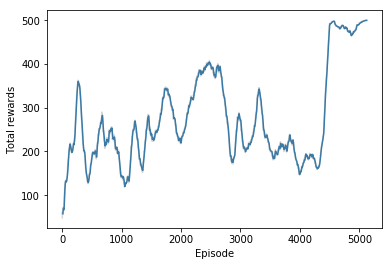

In [52]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

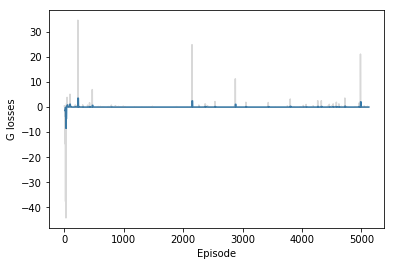

In [53]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

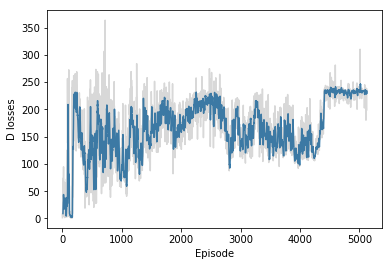

In [54]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses R')

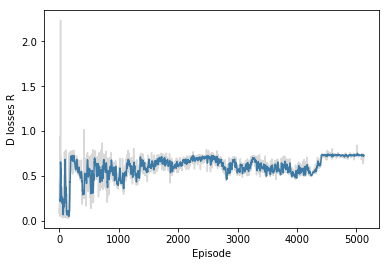

In [58]:
eps, arr = np.array(d_lossQsigm_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

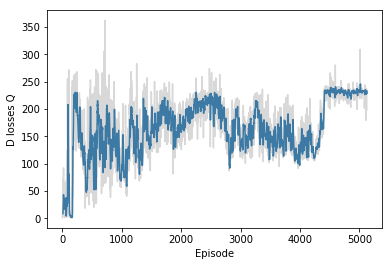

In [59]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [ ]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(11):
        state = env.reset()
        total_reward = 0
        g_initial_state = sess.run(model.g_initial_state)
        d_initial_state = sess.run(model.d_initial_state)

        # Training steps/batches
        while True:
            # Testing/inference
            env.render()
            action_logits, g_initial_state, d_initial_state = sess.run(
                fetches=[model.actions_logits, model.g_final_state, model.d_final_state], 
                feed_dict={model.states: np.reshape(state, [1, -1]),
                           model.g_initial_state: g_initial_state, 
                           model.d_initial_state: d_initial_state})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
# Closing the env
print('total_reward: {}'.format(total_reward))
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.